In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [7]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [8]:
plt.style.use('fivethirtyeight')

In [9]:
shotchart_all = ShotChartDetail(player_id=0, team_id=0, context_measure_simple='FGA', season_nullable='2023-24').get_data_frames()[0]

shotchart_all.LOC_X = -shotchart_all.LOC_X

In [10]:
three_df = shotchart_all.loc[shotchart_all.SHOT_TYPE == '3PT Field Goal']
three_df = three_df.loc[three_df.SHOT_DISTANCE <= 42]  # only half court shots
three_df.loc[:, 'CALC_DISTANCE'] = ((three_df.LOC_X ** 2) + (three_df.LOC_Y ** 2)) ** (1/2) / 10

grouped_data = three_df.groupby(['PLAYER_NAME', 'PLAYER_ID']).agg({
    'SHOT_DISTANCE': 'mean',
    'CALC_DISTANCE': 'mean',
    'SHOT_ATTEMPTED_FLAG': 'sum'
}).reset_index()
grouped_data = grouped_data.sort_values(by='SHOT_ATTEMPTED_FLAG', ascending=False).iloc[:150]
grouped_data.loc[:, 'SEASON'] = '2023-24'
grouped_data.loc[:, 'CALC_DISTANCE_M'] = grouped_data.CALC_DISTANCE * 0.3048
three_df.loc[:, 'CALC_DISTANCE_M'] = three_df.CALC_DISTANCE * 0.3048


In [11]:
last_season_distance = grouped_data.sort_values(by='CALC_DISTANCE_M', ascending=False).iloc[:40]

In [12]:
dist_data_print = []
for i in range(len(last_season_distance)):
    item = last_season_distance.iloc[i]
    subset = three_df.loc[(three_df.PLAYER_NAME == item.PLAYER_NAME) & (three_df.CALC_DISTANCE_M >= 8)]
    dist_data_print.append(
        {
            'PLAYER_ID': item.PLAYER_ID,
            'PLAYER_NAME': item.PLAYER_NAME,
            'FGM': subset.SHOT_MADE_FLAG.sum(),
            'FGA': subset.SHOT_ATTEMPTED_FLAG.sum(),
            'FG_PCT': (subset.SHOT_MADE_FLAG.sum() / subset.SHOT_ATTEMPTED_FLAG.sum()) * 100
        }
    )
df = pd.DataFrame(dist_data_print)

In [13]:
df = pd.DataFrame(dist_data_print)

In [14]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    #print(path)
    return OffsetImage(plt.imread(path), zoom=1.0)


In [15]:
paths = []
for i in range(len(df)):
    item = df.iloc[i]
    paths.append(f'player_imgs/{item.PLAYER_ID}.png')


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

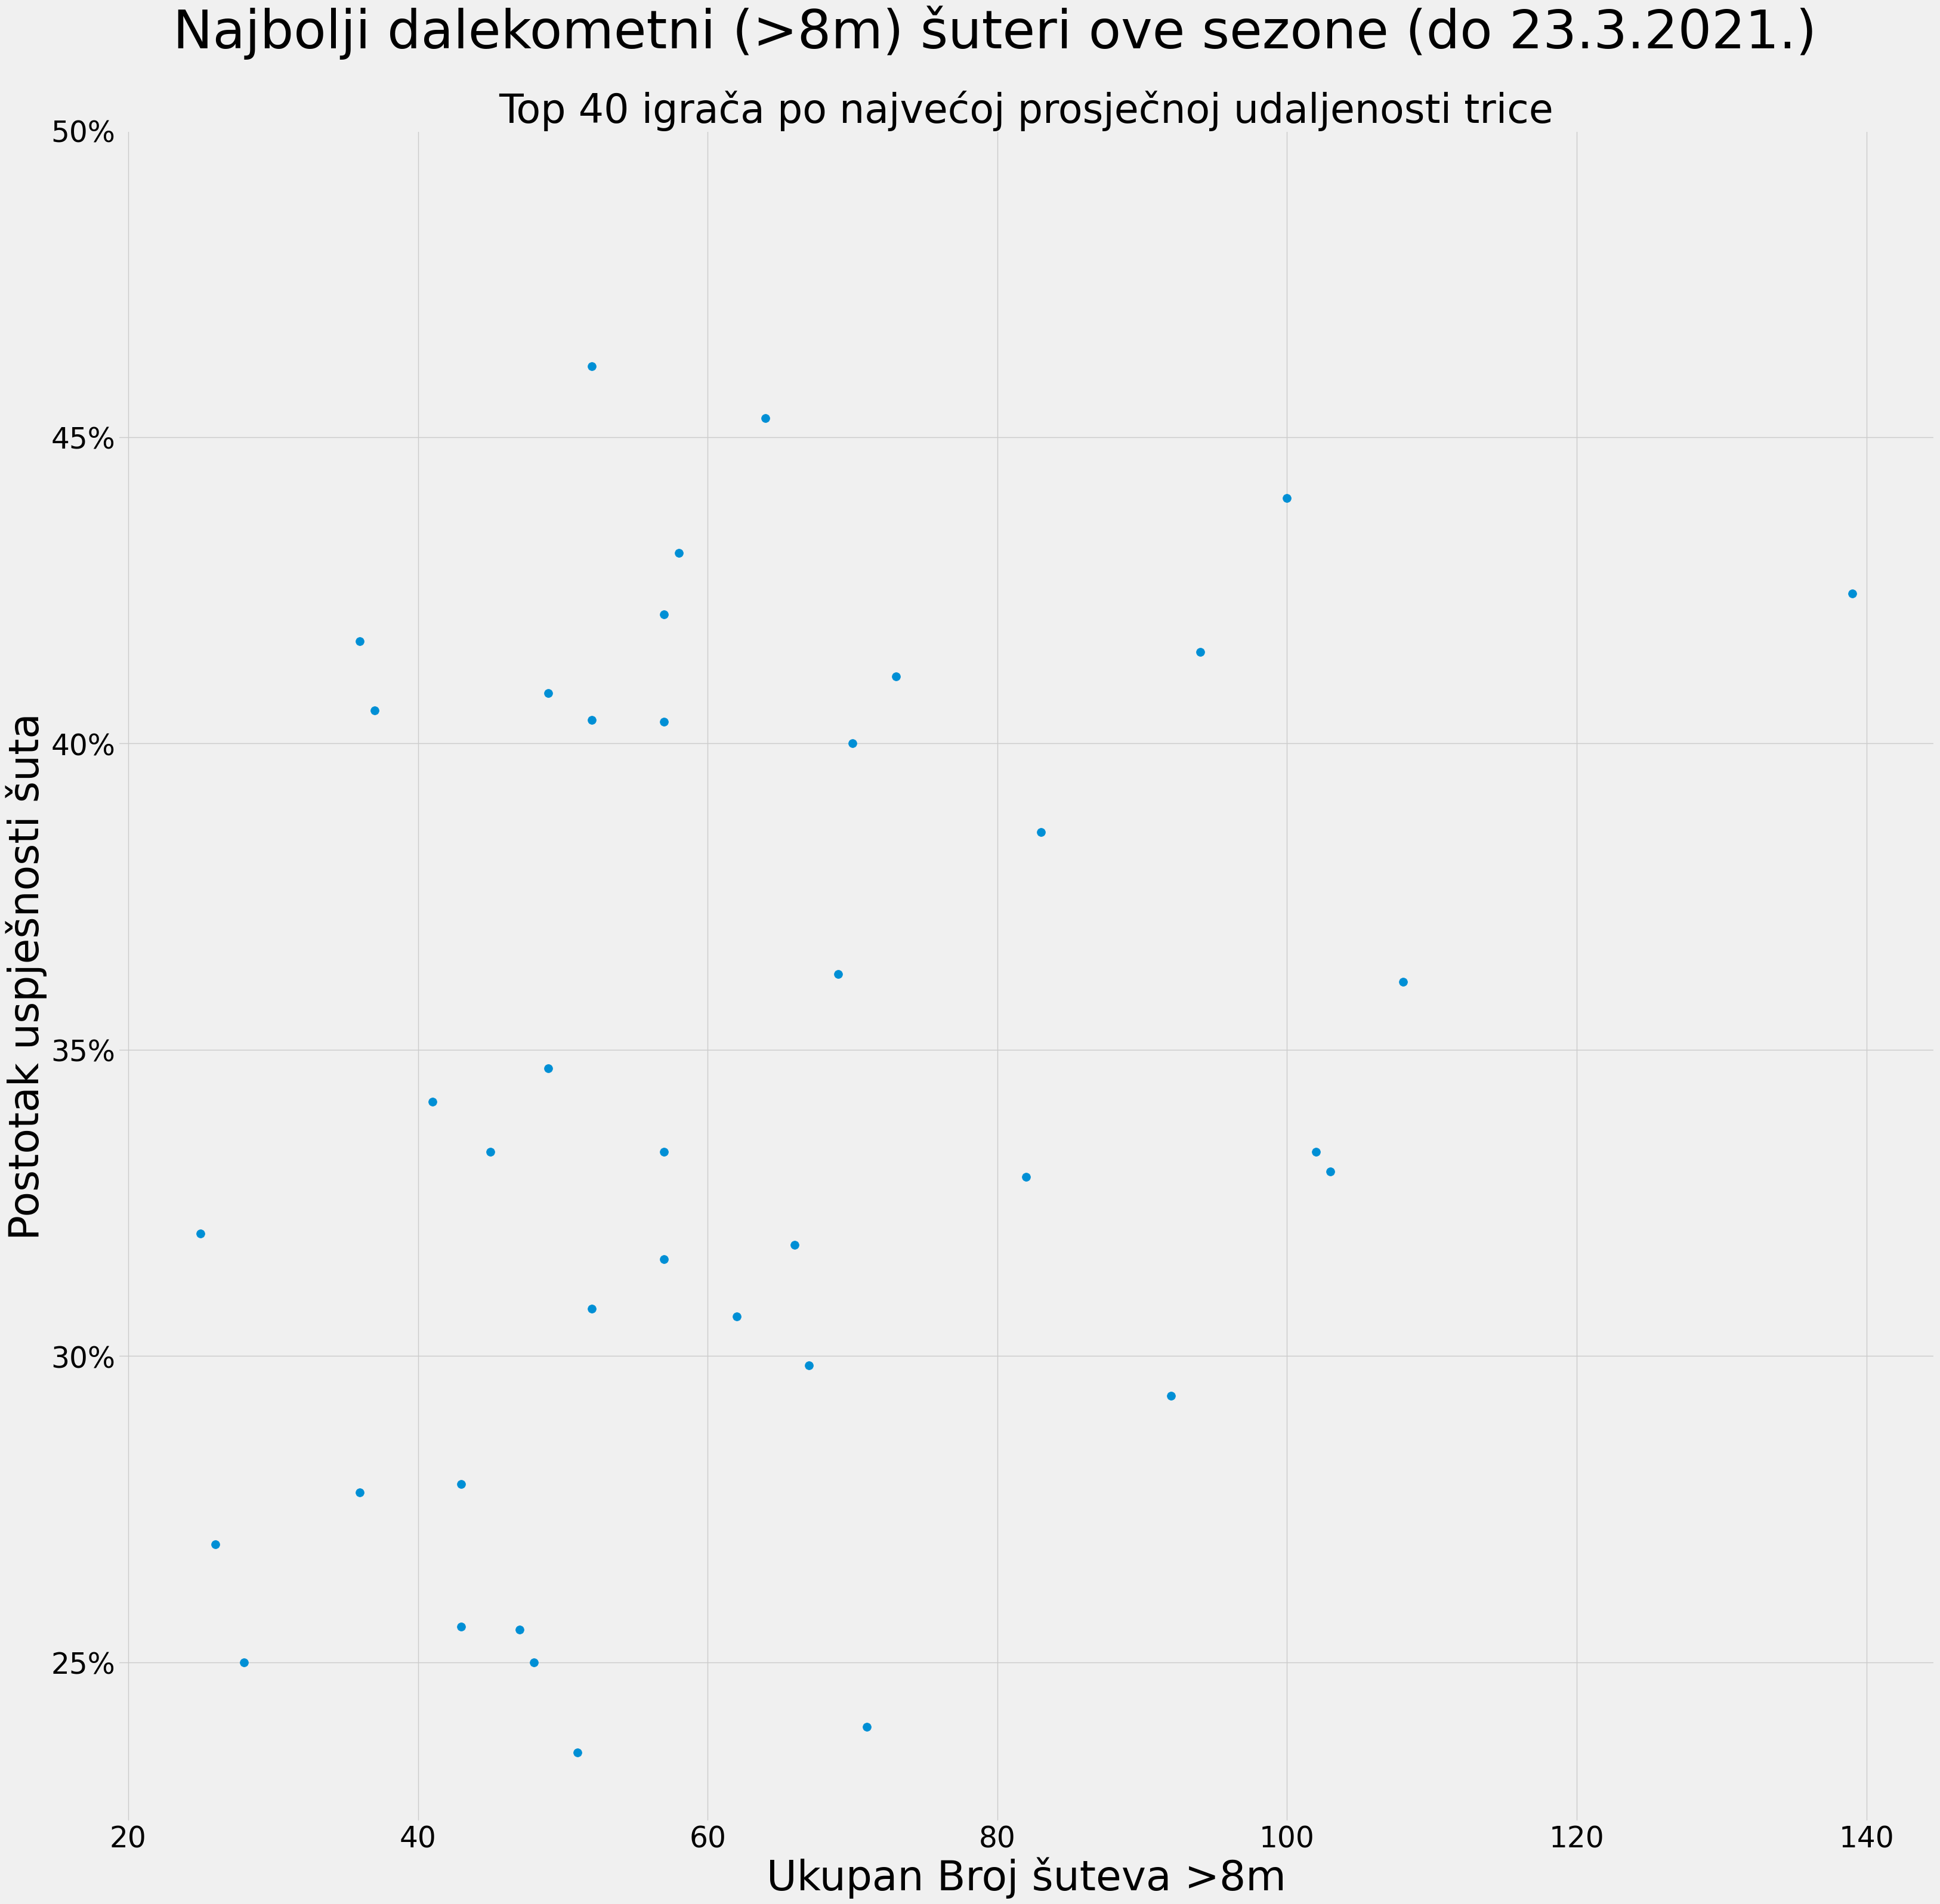

In [16]:
fig, ax = plt.subplots(figsize=(35, 35))


x = df.FGA.tolist()
y = df.FG_PCT.tolist()

ax.scatter(x=df.FGA, y=df.FG_PCT, s=100)

ax.tick_params(labelsize=35)
ax.set_xlabel("Ukupan Broj šuteva >8m", size=50)
ax.set_ylabel("Postotak uspješnosti šuta", size=50)
fig.suptitle("Najbolji dalekometni (>8m) šuteri ove sezone (do 23.3.2021.)", size=64, y=0.94)
ax.set_title("Top 40 igrača po najvećoj prosječnoj udaljenosti trice", size=48)
#ax.set_yticklabels([f"{item}%" for item in range(15, 55, 5)])

ax.set_yticks([item for item in range(25, 52, 5)])
vals = ax.get_yticks()
ax.set_yticklabels([f'{int(x)}%' for x in vals])
ax.grid(True, alpha=1.0, lw=1.5)
texts = []
for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path), (x0, y0+1), frameon=False)
    texts.append(ab)
    ax.add_artist(ab)
    
ax.text(x=df.FGA.max()-5, y=df.FG_PCT.min()-2.5, ha='right', s='twitter: @daniel_bratulic', size=24)
ax.text(x=df.FGA.min(), y=df.FG_PCT.min()-2.5, ha='left', s='source: stats.nba.com', size=24)

In [37]:
long_range_shooters = grouped_data.sort_values(by='CALC_DISTANCE', ascending=False).iloc[:60]

In [38]:
dist_data_print = []
for i in range(len(last_season_distance)):
    item = last_season_distance.iloc[i]
    subset = three_df.loc[(three_df.PLAYER_NAME == item.PLAYER_NAME) & (three_df.CALC_DISTANCE >= 28)]
    dist_data_print.append(
        {
            'PLAYER_ID': item.PLAYER_ID,
            'PLAYER_NAME': item.PLAYER_NAME,
            'FGM': subset.SHOT_MADE_FLAG.sum(),
            'FGA': subset.SHOT_ATTEMPTED_FLAG.sum(),
            'FG_PCT': (subset.SHOT_MADE_FLAG.sum() / subset.SHOT_ATTEMPTED_FLAG.sum()) * 100
        }
    )
df = pd.DataFrame(dist_data_print)

In [47]:
top_players = df.sort_values(by='FGA', ascending=False).iloc[:20].reset_index()

In [55]:
paths = []
for i in range(len(top_players)):
    item = top_players.iloc[i]
    paths.append(f'player_imgs/{item.PLAYER_ID}.png')


C:\Users\danie\AppData\Local\Temp\ipykernel_7620\2490267190.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(x)}%' for x in vals])


Text(18, 10.75, 'source: stats.nba.com')

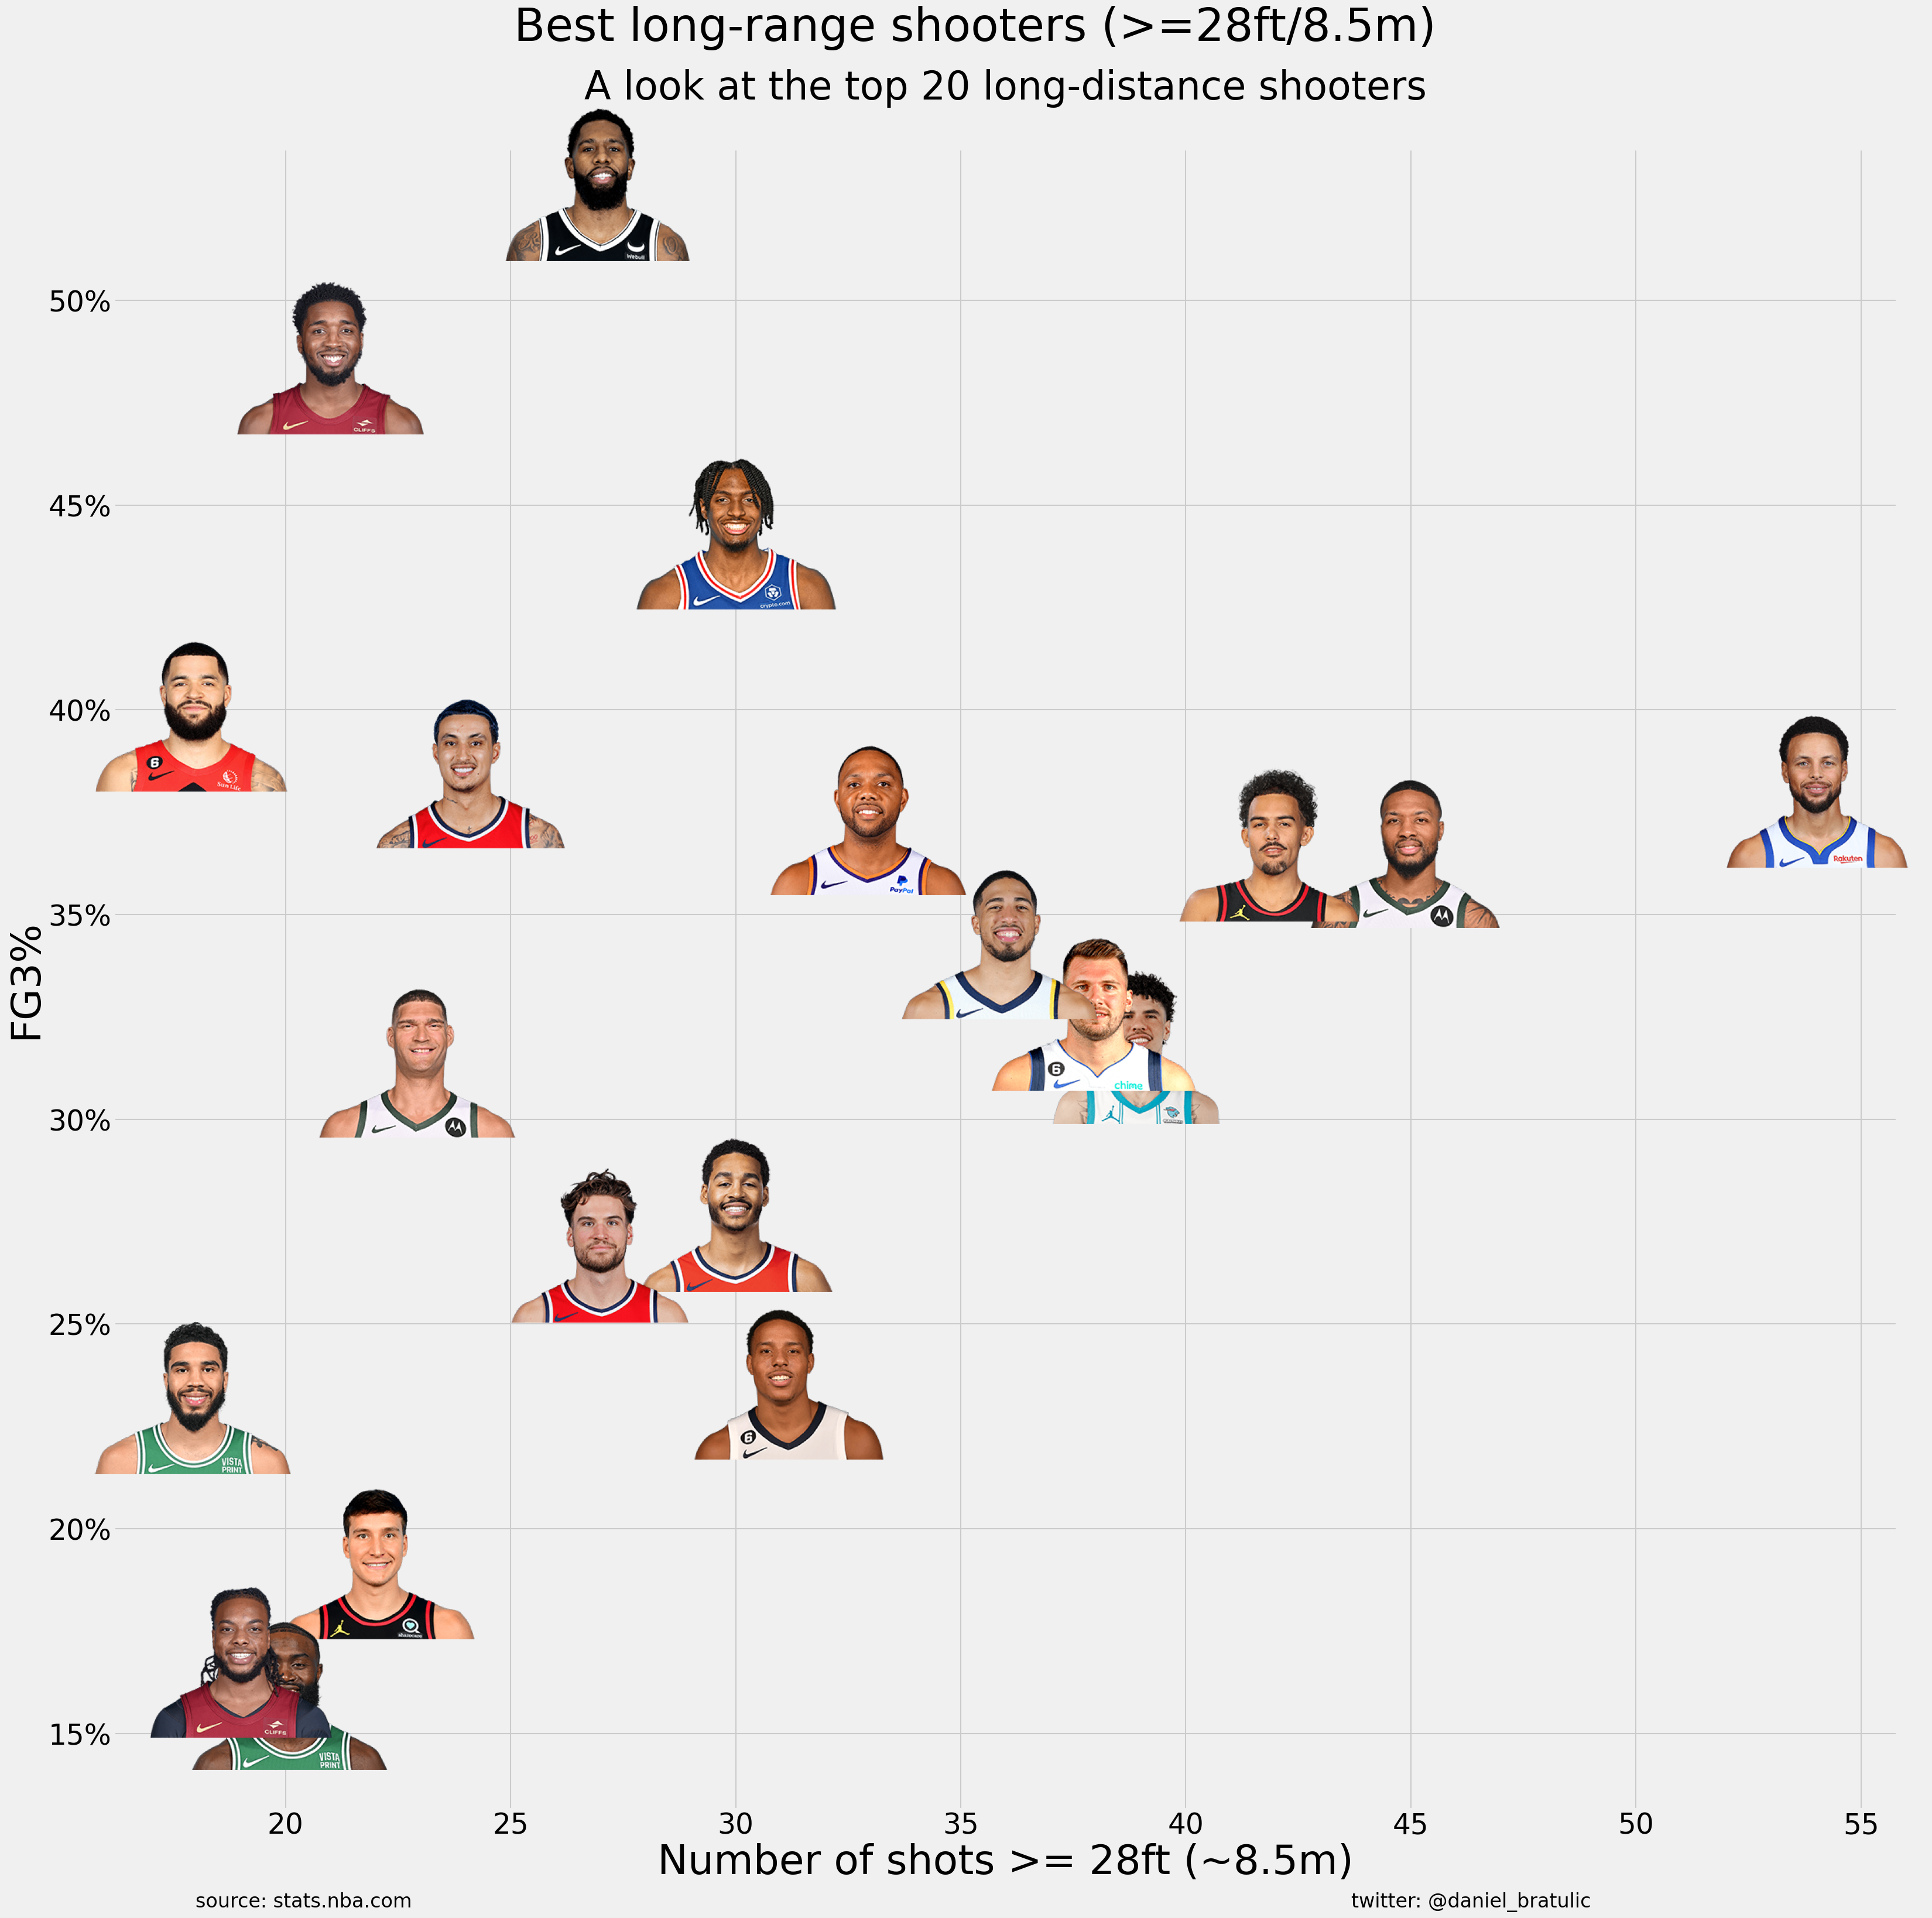

In [56]:
fig, ax = plt.subplots(figsize=(35, 35))


x = top_players.FGA.tolist()
y = top_players.FG_PCT.tolist()

ax.scatter(x=top_players.FGA, y=top_players.FG_PCT)

ax.tick_params(labelsize=35)
ax.set_xlabel("Number of shots >= 28ft (~8.5m)", size=50)
ax.set_ylabel("FG3%", size=50)
fig.suptitle("Best long-range shooters (>=28ft/8.5m)", size=56, y=0.95)
ax.set_title("A look at the top 20 long-distance shooters", size=48, y=1.025, pad=10)
#ax.set_yticklabels([f"{item}%" for item in range(15, 55, 5)])

vals = ax.get_yticks()
ax.set_yticklabels([f'{int(x)}%' for x in vals])
ax.grid(True, alpha=1.0, lw=1.5)
texts = []
for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path), (x0, y0+1), frameon=False)
    texts.append(ab)
    ax.add_artist(ab)
    

ax.text(x=top_players.FGA.max()-5, y=top_players.FG_PCT.min()-4.25, ha='right', s='twitter: @daniel_bratulic', size=24)
ax.text(x=top_players.FGA.min(), y=top_players.FG_PCT.min()-4.25, ha='left', s='source: stats.nba.com', size=24)

In [28]:
print(df.loc[df.FGA >= 40].to_string())

    PLAYER_ID         PLAYER_NAME  FGM  FGA     FG_PCT
0     1629027          Trae Young   34  103  33.009709
1      203081      Damian Lillard   34  102  33.333333
2      201939       Stephen Curry   59  139  42.446043
3     1630169   Tyrese Haliburton   39   94  41.489362
4     1630178        Tyrese Maxey   44  100  44.000000
5     1630163         LaMelo Ball   27   82  32.926829
6     1629636      Darius Garland   11   43  25.581395
7      204001  Kristaps Porzingis   21   52  40.384615
8     1629029         Luka Doncic   39  108  36.111111
9      201569         Eric Gordon   32   83  38.554217
10    1630557       Corey Kispert   19   57  33.333333
11    1628398          Kyle Kuzma   17   71  23.943662
12    1629673        Jordan Poole   20   67  29.850746
13       2544        LeBron James   29   64  45.312500
14    1628378    Donovan Mitchell   25   69  36.231884
15    1630559       Austin Reaves   20   49  40.816327
16    1627832       Fred VanVleet   28   70  40.000000
18    1626

In [19]:
print(df.loc[df.FGA >= 100].to_string())

   PLAYER_ID     PLAYER_NAME  FGM  FGA     FG_PCT
0    1629027      Trae Young   34  103  33.009709
1     203081  Damian Lillard   34  102  33.333333
2     201939   Stephen Curry   59  139  42.446043
4    1630178    Tyrese Maxey   44  100  44.000000
8    1629029     Luka Doncic   39  108  36.111111


Trae Young 108 šuteva uz 37.03%
Eric Gordon 109 šuteva uz 33.94%
Davis Bertans 115 šuteva uz 33.91%
Luka Doncic 106 šuteva uz 34.90%
Malcolm Brogdon  99 šuteva uz 34.34%
LeBron James 100 šuteva uz 35.00%
Fred VanVleet 126 šuteva uz 38.88%
James Harden  99 šuteva uz 35.35%

In [186]:
dist_data_print = []
for i in range(len(last_season_distance)):
    item = last_season_distance.iloc[i]
    subset = three_df.loc[(three_df.PLAYER_NAME == item.PLAYER_NAME) & (three_df.CALC_DISTANCE_M >= 9)]
    dist_data_print.append(
        {
            'PLAYER_ID': item.PLAYER_ID,
            'PLAYER_NAME': item.PLAYER_NAME,
            'FGM': subset.SHOT_MADE_FLAG.sum(),
            'FGA': subset.SHOT_ATTEMPTED_FLAG.sum(),
            'FG_PCT': (subset.SHOT_MADE_FLAG.sum() / subset.SHOT_ATTEMPTED_FLAG.sum()) * 100
        }
    )

In [187]:
df = pd.DataFrame(dist_data_print)

In [189]:
df.sort_values(by='FGA', ascending=False)

PLAYER_ID            PLAYER_NAME  FGM  FGA      FG_PCT
1      203081         Damian Lillard   32   93   34.408602
0     1629027             Trae Young   25   66   37.878788
3      201939          Stephen Curry   17   47   36.170213
7     1627832          Fred VanVleet   11   27   40.740741
8     1630163            LaMelo Ball    7   21   33.333333
2      201569            Eric Gordon    6   18   33.333333
9      200768             Kyle Lowry    5   18   27.777778
5      202722          Davis Bertans    6   18   33.333333
13    1630193      Immanuel Quickley    5   16   31.250000
4      204001     Kristaps Porzingis    4   15   26.666667
16     202681           Kyrie Irving    7   14   50.000000
19    1626164           Devin Booker    5   13   38.461538
30    1627750           Jamal Murray    6   13   46.153846
25    1628378       Donovan Mitchell    6   13   46.153846
10       2544           LeBron James    4   13   30.769231
6     1629029            Luka Doncic    3   12   25.000000
26     201568       Danilo Gallinari    3   10   30.000000
14    1627763        Malcolm Brogdon    4    9   44.444444
32     203506         Victor Oladipo    2    8   25.000000
20    1628369           Jayson Tatum    4    8   50.000000
17    1626192        Pat Connaughton    2    8   25.000000
15     201935           James Harden    2    8   25.000000
34     201571          D.J. Augustin    2    7   28.571429
38    1629012          Collin Sexton    1    7   14.285714
31    1626156       D'Angelo Russell    2    7   28.571429
39    1627759           Jaylen Brown    2    6   33.333333
23    1628370             Malik Monk    0    6    0.000000
24     203078           Bradley Beal    1    6   16.666667
27    1628984        Devonte' Graham    0    6    0.000000
37    1629726       Garrison Mathews    3    6   50.000000
22    1628978       Donte DiVincenzo    2    5   40.000000
29    1629636         Darius Garland    2    5   40.000000
35    1629639            Tyler Herro    1    3   33.333333
12     203507  Giannis Antetokounmpo    0    3    0.000000
11     201566      Russell Westbrook    1    3   33.333333
21     202322              John Wall    0    3    0.000000
33     202696         Nikola Vucevic    2    2  100.000000
36     203552             Seth Curry    2    2  100.000000
28     101108             Chris Paul    0    2    0.000000
18     202689           Kemba Walker    0    2    0.000000

### Trend of triples

In [16]:
seasons = [f"{item}-{str(item+1)[-2:]}" for item in range(1999, 2020)]

In [15]:
three_df = shotchart_all.loc[shotchart_all.SHOT_TYPE == '3PT Field Goal']
three_df = three_df.loc[three_df.SHOT_DISTANCE <= 42]  # only half court shots
three_df.loc[:, 'CALC_DISTANCE'] = ((three_df.LOC_X ** 2) + (three_df.LOC_Y ** 2)) ** (1/2) / 10

grouped_data = three_df.groupby(['PLAYER_NAME', 'PLAYER_ID']).agg({
    'SHOT_DISTANCE': 'mean',
    'CALC_DISTANCE': 'mean',
    'SHOT_ATTEMPTED_FLAG': 'sum'
}).reset_index()

grouped_data = grouped_data.sort_values(by='SHOT_ATTEMPTED_FLAG', ascending=False).iloc[:150]
grouped_data.loc[:, 'SEASON'] = '2020-21'
grouped_data.loc[:, 'CALC_DISTANCE_M'] = grouped_data.CALC_DISTANCE * 0.3048
three_df.loc[:, 'CALC_DISTANCE_M'] = three_df.CALC_DISTANCE * 0.3048


In [16]:
distance_dfs = []

for season in tqdm.tqdm(seasons):
    #shot_df = ShotChartDetail(player_id=0, team_id=0, context_measure_simple='FGA', season_nullable=season).get_data_frames()[0]
    shot_df = pd.read_csv(f'shots/{season}.csv')
    three_df = shot_df.loc[shot_df.SHOT_TYPE == '3PT Field Goal']
    three_df = three_df.loc[three_df.SHOT_DISTANCE <= 42]  # only half court shots
    three_df.loc[:, 'CALC_DISTANCE'] = ((three_df.LOC_X ** 2) + (three_df.LOC_Y ** 2)) ** (1/2) / 10
    grouped_data = three_df.groupby('PLAYER_NAME').agg({
        'SHOT_DISTANCE': 'mean',
        'CALC_DISTANCE': 'mean',
        'SHOT_ATTEMPTED_FLAG': 'sum'
    }).reset_index()
    grouped_data = grouped_data.sort_values(by='SHOT_ATTEMPTED_FLAG', ascending=False)
    grouped_data.loc[:, 'CALC_DISTANCE_M'] = grouped_data.CALC_DISTANCE * 0.3048
    grouped_data.loc[:, 'SEASON'] = season
    distance_dfs.append(grouped_data)
    #time.sleep(0.5)
    
three_df = shotchart_all.loc[shotchart_all.SHOT_TYPE == '3PT Field Goal']
three_df = three_df.loc[three_df.SHOT_DISTANCE <= 42]  # only half court shots
three_df.loc[:, 'CALC_DISTANCE'] = ((three_df.LOC_X ** 2) + (three_df.LOC_Y ** 2)) ** (1/2) / 10

grouped_data = three_df.groupby('PLAYER_NAME').agg({
    'SHOT_DISTANCE': 'mean',
    'CALC_DISTANCE': 'mean',
    'SHOT_ATTEMPTED_FLAG': 'sum'
}).reset_index()
grouped_data = grouped_data.sort_values(by='SHOT_ATTEMPTED_FLAG', ascending=False)
grouped_data.loc[:, 'CALC_DISTANCE_M'] = grouped_data.CALC_DISTANCE * 0.3048
three_df.loc[:, 'CALC_DISTANCE_M'] = three_df.CALC_DISTANCE * 0.3048
grouped_data.loc[:, 'SEASON'] = '2020-21'
distance_dfs.append(grouped_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:28<00:00,  1.36s/it]


In [17]:
full_distance_df = pd.concat(distance_dfs)

In [27]:
averages = full_distance_df.groupby('SEASON').SHOT_DISTANCE.mean().to_frame().reset_index()

In [19]:
averages = averages.rename(columns={'CALC_DISTANCE': 'AVERAGE_DISTANCE'})

In [20]:
merged_distance = pd.merge(left=full_distance_df, right=averages, on='SEASON')

In [21]:
merged_distance.loc[:, 'DIFF_FROM_AVG'] = merged_distance.CALC_DISTANCE - merged_distance.AVERAGE_DISTANCE

In [22]:
merged_distance.loc[:, 'CALC_DISTANCE_M'] = merged_distance.CALC_DISTANCE * 0.3048
merged_distance.loc[:, 'AVERAGE_DISTANCE_M'] = merged_distance.AVERAGE_DISTANCE * 0.3048
merged_distance.loc[:, 'DIFF_FROM_AVG_M'] = merged_distance.DIFF_FROM_AVG * 0.3048

In [23]:
merged_distance = merged_distance.loc[:, ['PLAYER_NAME', 'SEASON', 'CALC_DISTANCE_M', 'AVERAGE_DISTANCE_M', 'DIFF_FROM_AVG_M', 'CALC_DISTANCE', 'AVERAGE_DISTANCE', 'DIFF_FROM_AVG']]

In [28]:
averages

SEASON  SHOT_DISTANCE
0   1999-00      25.112738
1   2000-01      25.450974
2   2001-02      25.040884
3   2002-03      24.959428
4   2003-04      25.042701
5   2004-05      24.843432
6   2005-06      24.903128
7   2006-07      25.157621
8   2007-08      24.822828
9   2008-09      24.977451
10  2009-10      24.873033
11  2010-11      25.019487
12  2011-12      25.078212
13  2012-13      24.920836
14  2013-14      24.799627
15  2014-15      24.604419
16  2015-16      24.643175
17  2016-17      24.646496
18  2017-18      24.775988
19  2018-19      24.840930
20  2019-20      24.839147
21  2020-21      24.893447

## AVERAGE DISTANCE THROUGH TIME

In [106]:
distance_dfs = []

for season in tqdm.tqdm(seasons):
    #shot_df = ShotChartDetail(player_id=0, team_id=0, context_measure_simple='FGA', season_nullable=season).get_data_frames()[0]
    shot_df = pd.read_csv(f'shots/{season}.csv')
    three_df = shot_df.loc[shot_df.SHOT_TYPE == '3PT Field Goal']
    three_df = three_df.loc[three_df.SHOT_DISTANCE <= 42]  # only half court shots
    three_df.loc[:, 'CALC_DISTANCE'] = ((three_df.LOC_X ** 2) + (three_df.LOC_Y ** 2)) ** (1/2) / 10
    three_df.loc[:, 'SEASON'] = season
    distance_dfs.append(three_df)
    #time.sleep(0.5)
    
three_df = shotchart_all.loc[shotchart_all.SHOT_TYPE == '3PT Field Goal']
three_df = three_df.loc[three_df.SHOT_DISTANCE <= 42]  # only half court shots
three_df.loc[:, 'CALC_DISTANCE'] = ((three_df.LOC_X ** 2) + (three_df.LOC_Y ** 2)) ** (1/2) / 10
three_df.loc[:, 'SEASON'] = '2020-21'
distance_dfs.append(three_df)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:29<00:00,  1.38s/it]


In [107]:
full_distance_df = pd.concat(distance_dfs)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [108]:
averages = full_distance_df.groupby('SEASON').CALC_DISTANCE.mean().to_frame().reset_index()

In [109]:
averages = averages.rename(columns={'CALC_DISTANCE': 'AVERAGE_DISTANCE'})

In [110]:
meters_dist = averages.AVERAGE_DISTANCE * 0.3048

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


Text(0, 7.564168772966937, 'source: stats.nba.com')

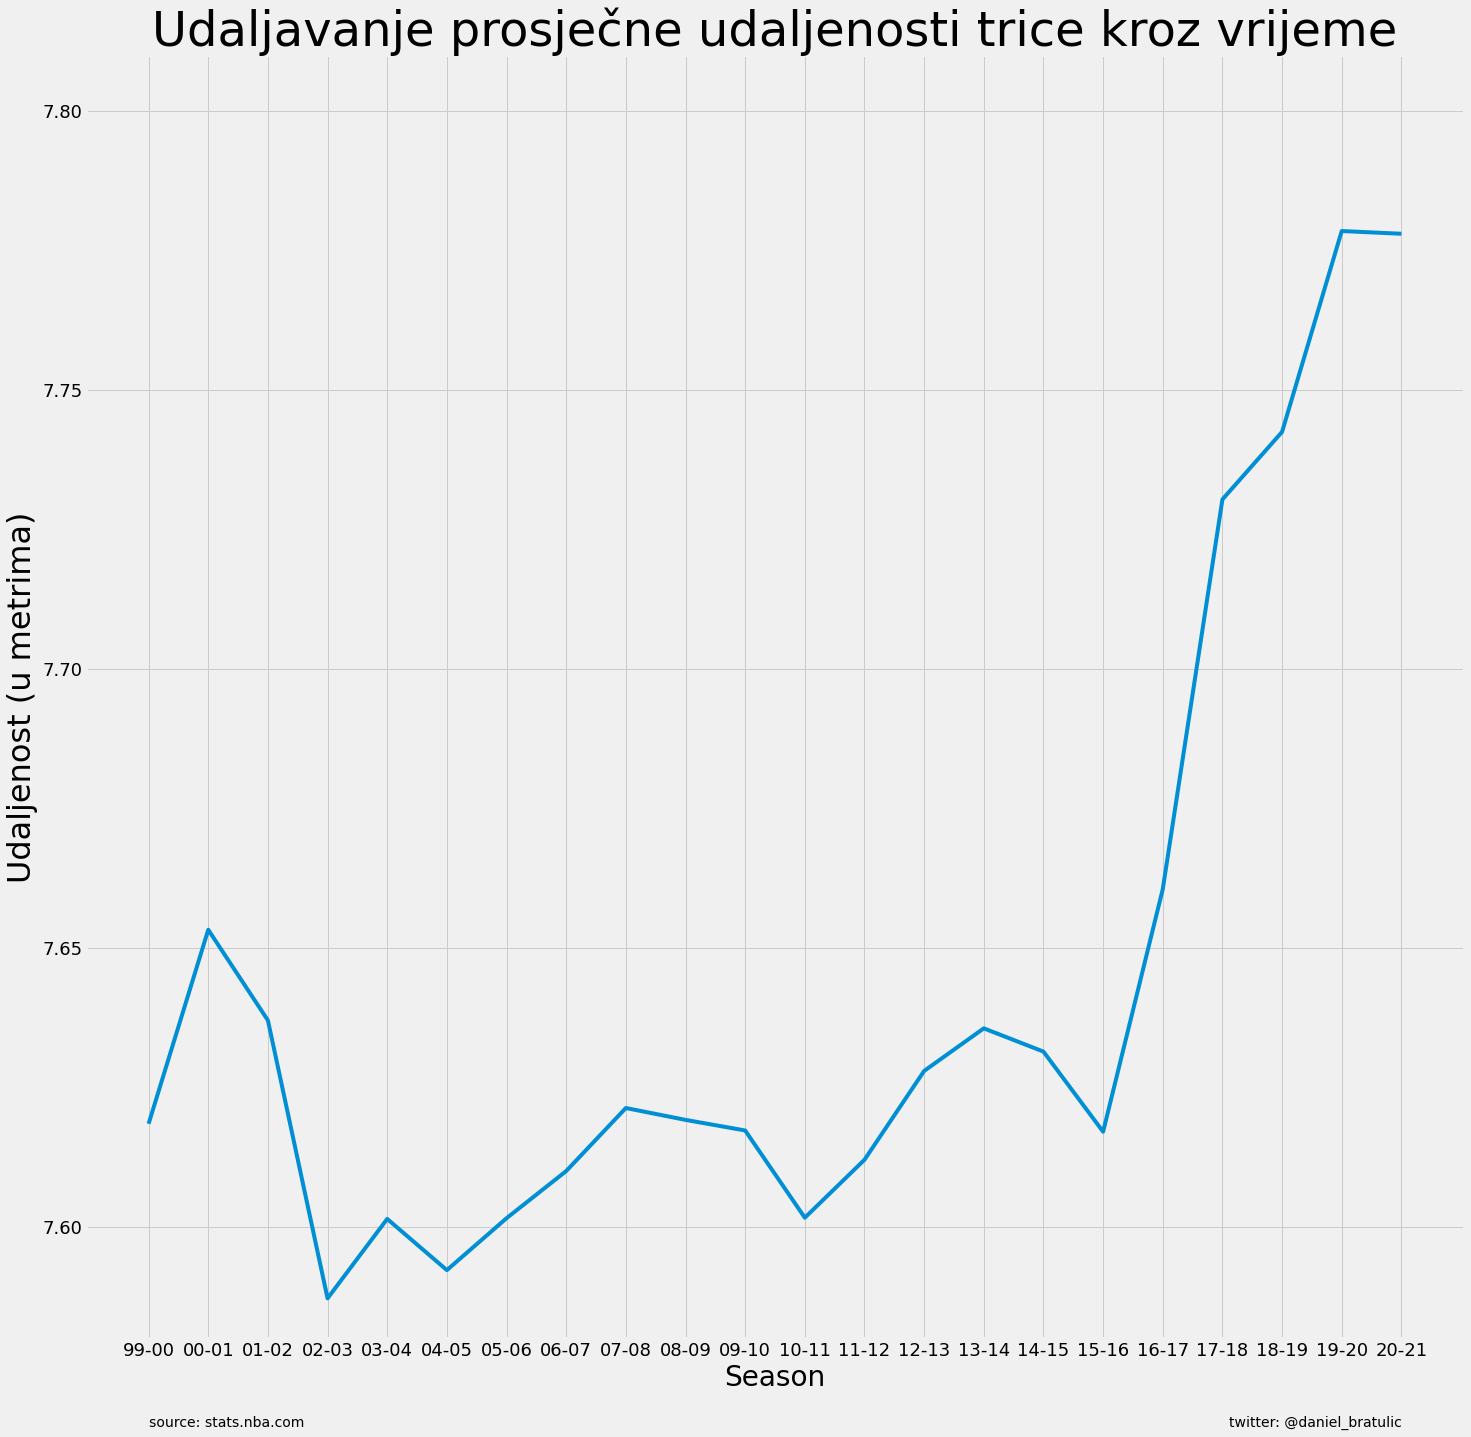

In [121]:
fig, ax = plt.subplots(figsize=(22, 22))

ax.plot(seasons + ['2020-21'], meters_dist)
ax.set_xlabel("Season", size=28)
ax.set_ylabel("Udaljenost (u metrima)", size=32)
#fig.suptitle("Udaljavanje prosječne udaljenosti trice kroz vrijeme", size=48, y=0.945)
ax.set_title("Udaljavanje prosječne udaljenosti trice kroz vrijeme", size=48)
ax.tick_params(labelsize=18)
_ = ax.set_xticklabels([item[2:] for item in seasons + ['2020-21']])
#ax.set_yticks([item for item in range(7.55, 7.8, 0.05)])
ax.set_ylim([7.58, 7.81])


ax.text(x=len(seasons), y=meters_dist.min()-0.023, ha='right', s='twitter: @daniel_bratulic', size=14)
ax.text(x=0, y=meters_dist.min()-0.023, ha='left', s='source: stats.nba.com', size=14)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


Text(0, 7.564168772966937, 'source: stats.nba.com')

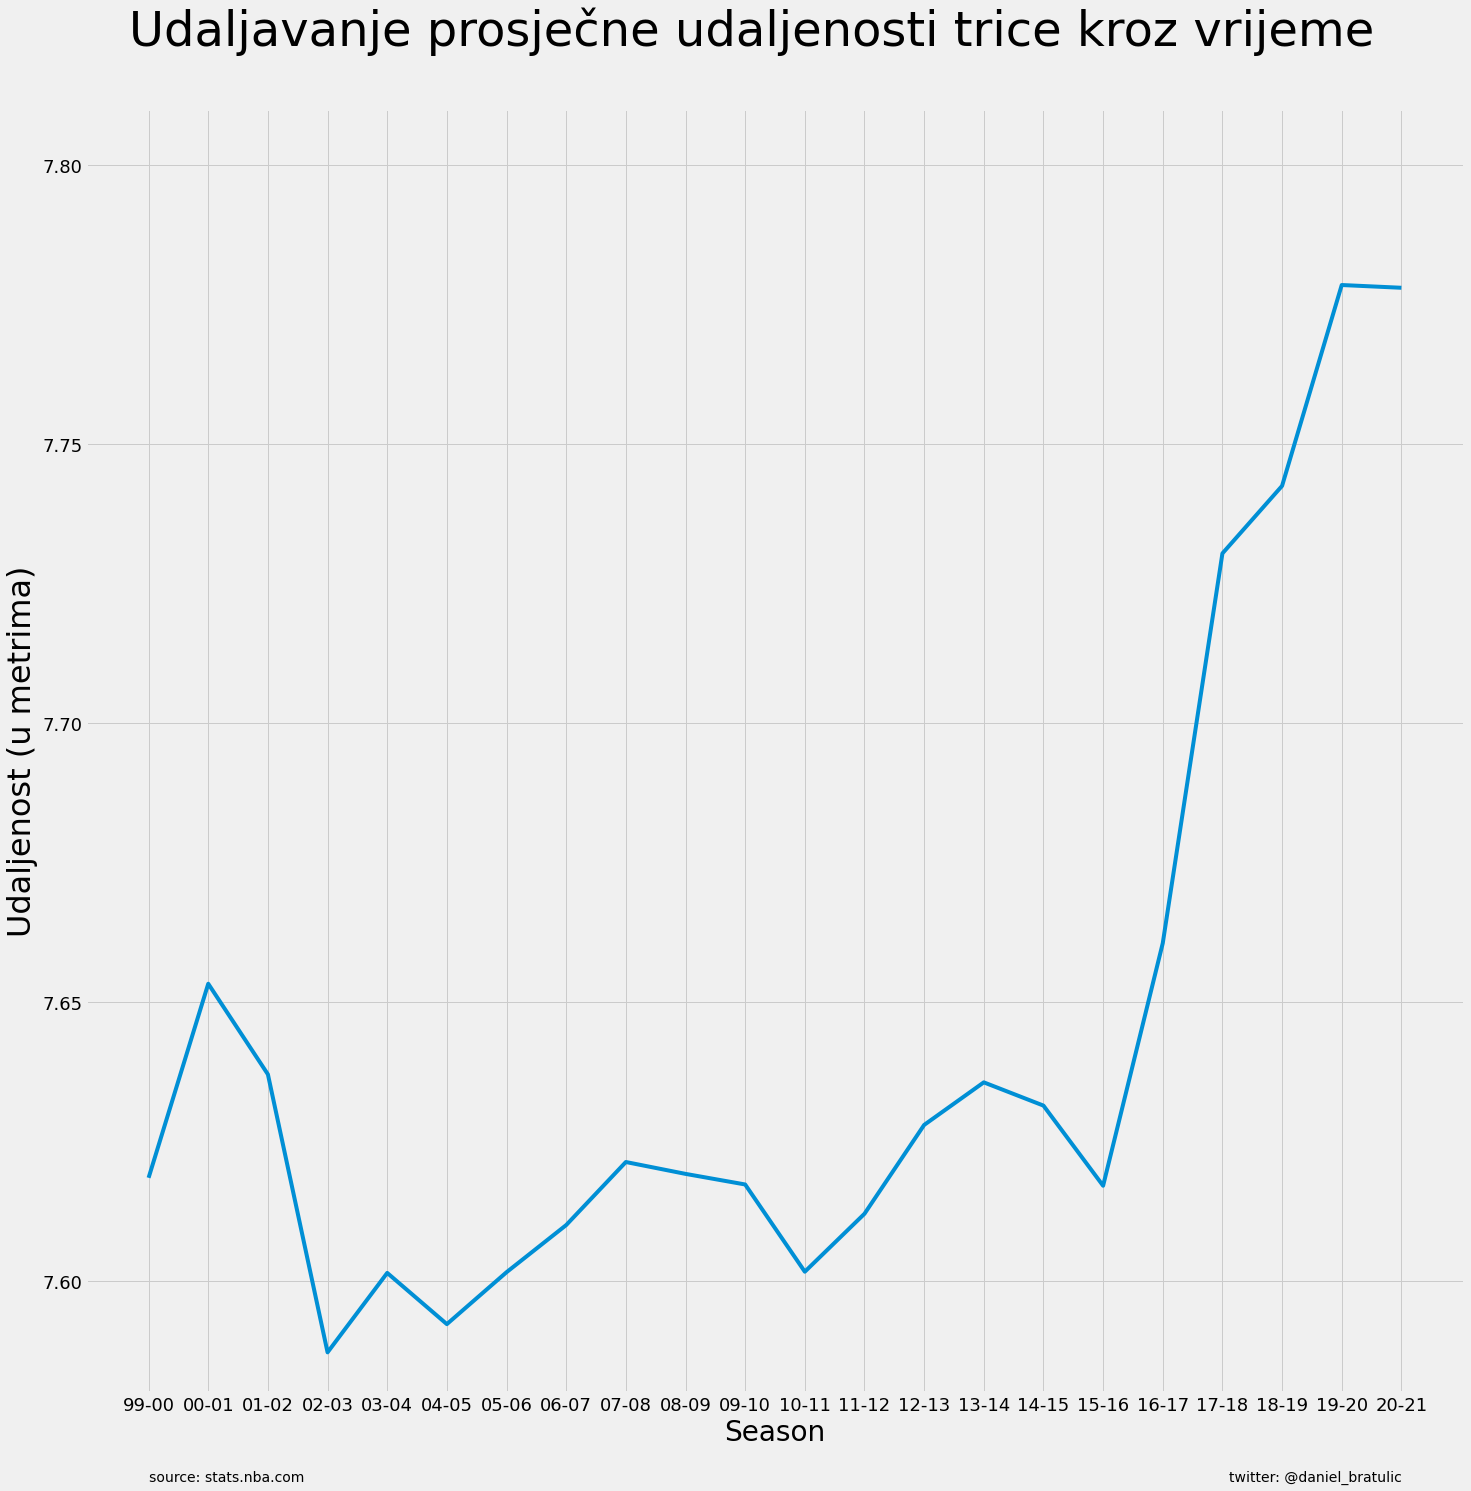

In [115]:
fig, ax = plt.subplots(figsize=(22, 22))

ax.plot(seasons + ['2020-21'], meters_dist)
ax.set_xlabel("Season", size=28)
ax.set_ylabel("Udaljenost (u metrima)", size=32)
fig.suptitle("Udaljavanje prosječne udaljenosti trice kroz vrijeme", size=48, y=0.945)
#ax.set_title("Promatra se top 100 igrača po broju upućenih trica svake sezone", size=28)
ax.tick_params(labelsize=18)
_ = ax.set_xticklabels([item[2:] for item in seasons + ['2020-21']])
#ax.set_ylim([7.54, 7.81])
ax.set_ylim([7.58, 7.81])



ax.text(x=len(seasons), y=meters_dist.min()-0.023, ha='right', s='twitter: @daniel_bratulic', size=14)
ax.text(x=0, y=meters_dist.min()-0.023, ha='left', s='source: stats.nba.com', size=14)

# Average through time (top 150 only)

In [164]:
distance_dfs = []

for season in tqdm.tqdm(seasons):
    #shot_df = ShotChartDetail(player_id=0, team_id=0, context_measure_simple='FGA', season_nullable=season).get_data_frames()[0]
    shot_df = pd.read_csv(f'shots/{season}.csv')
    three_df = shot_df.loc[shot_df.SHOT_TYPE == '3PT Field Goal']
    three_df = three_df.loc[three_df.SHOT_DISTANCE <= 42]  # only half court shots
    three_df.loc[:, 'CALC_DISTANCE'] = ((three_df.LOC_X ** 2) + (three_df.LOC_Y ** 2)) ** (1/2) / 10
    three_df.loc[:, 'SEASON'] = season
    
    grouped_data = three_df.groupby('PLAYER_NAME').agg({
        'SHOT_ATTEMPTED_FLAG': 'sum',
    }).reset_index()
    top_150 = grouped_data.sort_values(by='SHOT_ATTEMPTED_FLAG', ascending=False).iloc[:100]
    
    target_players = three_df.loc[three_df.PLAYER_NAME.isin(top_150.PLAYER_NAME.tolist())]
    distance_dfs.append(target_players)
    #time.sleep(0.5)
    
three_df = shotchart_all.loc[shotchart_all.SHOT_TYPE == '3PT Field Goal']
three_df = three_df.loc[three_df.SHOT_DISTANCE <= 42]  # only half court shots
three_df.loc[:, 'CALC_DISTANCE'] = ((three_df.LOC_X ** 2) + (three_df.LOC_Y ** 2)) ** (1/2) / 10
three_df.loc[:, 'SEASON'] = '2020-21'

grouped_data = three_df.groupby('PLAYER_NAME').agg({
    'SHOT_ATTEMPTED_FLAG': 'sum',
}).reset_index()
top_150 = grouped_data.sort_values(by='SHOT_ATTEMPTED_FLAG', ascending=False).iloc[:100]

target_players = three_df.loc[three_df.PLAYER_NAME.isin(top_150.PLAYER_NAME.tolist())]
distance_dfs.append(target_players)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:30<00:00,  1.47s/it]


In [165]:
average_distances_subset_df = pd.concat(distance_dfs)

averages = average_distances_subset_df.groupby('SEASON').CALC_DISTANCE.mean().to_frame().reset_index()

averages = averages.rename(columns={'CALC_DISTANCE': 'AVERAGE_DISTANCE'})

meters_dist = averages.AVERAGE_DISTANCE * 0.3048

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


Text(0, 7.565377353407572, 'source: stats.nba.com')

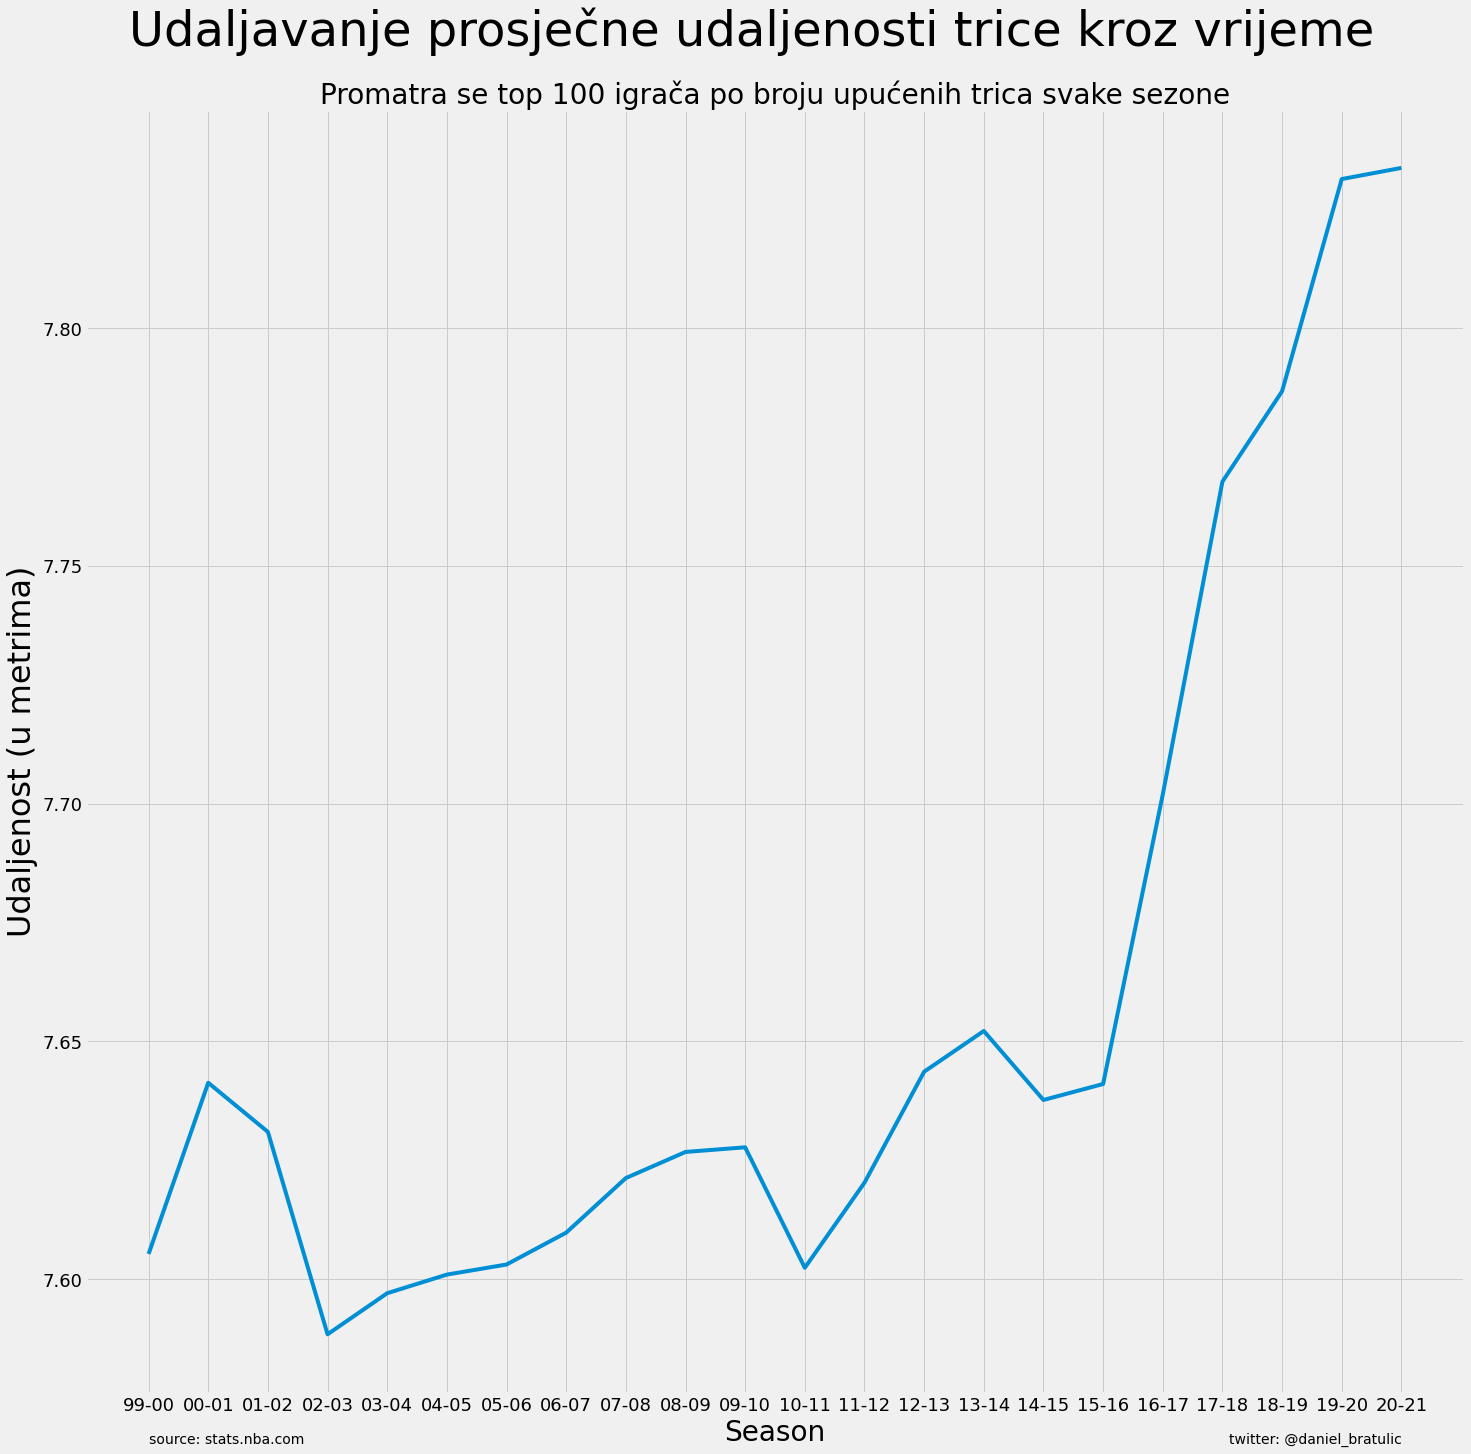

In [166]:
fig, ax = plt.subplots(figsize=(22, 22))

ax.plot(seasons + ['2020-21'], meters_dist)
ax.set_xlabel("Season", size=28)
ax.set_ylabel("Udaljenost (u metrima)", size=32)
fig.suptitle("Udaljavanje prosječne udaljenosti trice kroz vrijeme", size=48, y=0.945)
ax.set_title("Promatra se top 100 igrača po broju upućenih trica svake sezone", size=28)
ax.tick_params(labelsize=18)
_ = ax.set_xticklabels([item[2:] for item in seasons + ['2020-21']])
#ax.set_ylim([7.54, 7.81])


ax.text(x=len(seasons), y=meters_dist.min()-0.023, ha='right', s='twitter: @daniel_bratulic', size=14)
ax.text(x=0, y=meters_dist.min()-0.023, ha='left', s='source: stats.nba.com', size=14)

# Diff from avg

##### Iterate for top 100 shooters only??

In [17]:
shotchart_all = ShotChartDetail(player_id=0, team_id=0, context_measure_simple='FGA', season_nullable='2020-21').get_data_frames()[0]

shotchart_all.LOC_X = -shotchart_all.LOC_X

In [18]:
distance_dfs = []
average_dfs = []

for season in tqdm.tqdm(seasons):
    #shot_df = ShotChartDetail(player_id=0, team_id=0, context_measure_simple='FGA', season_nullable=season).get_data_frames()[0]
    shot_df = pd.read_csv(f'shots/{season}.csv')
    three_df = shot_df.loc[shot_df.SHOT_TYPE == '3PT Field Goal']
    three_df = three_df.loc[three_df.SHOT_DISTANCE <= 42]  # only half court shots
    three_df.loc[:, 'CALC_DISTANCE'] = ((three_df.LOC_X ** 2) + (three_df.LOC_Y ** 2)) ** (1/2) / 10
    three_df.loc[:, 'CALC_DISTANCE_M'] = three_df.CALC_DISTANCE * 0.3048
    three_df.loc[:, 'SEASON'] = season
    average_dfs.append(three_df)
    grouped_data = three_df.groupby('PLAYER_NAME').agg({
        'SHOT_DISTANCE': 'mean',
        'CALC_DISTANCE': 'mean',
        'SHOT_ATTEMPTED_FLAG': 'sum',
        'SHOT_MADE_FLAG': 'sum'
    }).reset_index()
    grouped_data = grouped_data.sort_values(by='SHOT_ATTEMPTED_FLAG', ascending=False).iloc[:50]
    grouped_data.loc[:, 'CALC_DISTANCE_M'] = grouped_data.CALC_DISTANCE * 0.3048
    grouped_data.loc[:, 'SEASON'] = season
    distance_dfs.append(grouped_data)
    #time.sleep(0.5)
    
three_df = shotchart_all.loc[shotchart_all.SHOT_TYPE == '3PT Field Goal']
three_df = three_df.loc[three_df.SHOT_DISTANCE <= 42]  # only half court shots
three_df.loc[:, 'CALC_DISTANCE'] = ((three_df.LOC_X ** 2) + (three_df.LOC_Y ** 2)) ** (1/2) / 10
three_df.loc[:, 'CALC_DISTANCE_M'] = three_df.CALC_DISTANCE * 0.3048
three_df.loc[:, 'SEASON'] = '2020-21'
average_dfs.append(three_df)

grouped_data = three_df.groupby('PLAYER_NAME').agg({
    'SHOT_DISTANCE': 'mean',
    'CALC_DISTANCE': 'mean',
    'SHOT_ATTEMPTED_FLAG': 'sum',
    'SHOT_MADE_FLAG': 'sum'
}).reset_index()
grouped_data = grouped_data.sort_values(by='SHOT_ATTEMPTED_FLAG', ascending=False).iloc[:50]
grouped_data.loc[:, 'CALC_DISTANCE_M'] = grouped_data.CALC_DISTANCE * 0.3048

grouped_data.loc[:, 'SEASON'] = '2020-21'
distance_dfs.append(grouped_data)

full_distance_df = pd.concat(distance_dfs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:35<00:00,  1.68s/it]


In [19]:
concated_averages = pd.concat(average_dfs)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [137]:
averages = concated_averages.groupby('SEASON').CALC_DISTANCE.mean().to_frame().reset_index()

In [138]:
averages = averages.rename(columns={'CALC_DISTANCE': 'AVERAGE_DISTANCE'})

In [139]:
full_distance_df = pd.concat(distance_dfs)

merged_distance = pd.merge(left=full_distance_df, right=averages, on='SEASON')

merged_distance.loc[:, 'DIFF_FROM_AVG'] = merged_distance.CALC_DISTANCE - merged_distance.AVERAGE_DISTANCE

merged_distance.loc[:, 'CALC_DISTANCE_M'] = merged_distance.CALC_DISTANCE * 0.3048
merged_distance.loc[:, 'AVERAGE_DISTANCE_M'] = merged_distance.AVERAGE_DISTANCE * 0.3048
merged_distance.loc[:, 'DIFF_FROM_AVG_M'] = merged_distance.DIFF_FROM_AVG * 0.3048

merged_distance = merged_distance.loc[:, ['PLAYER_NAME', 'SEASON', 'CALC_DISTANCE_M', 'AVERAGE_DISTANCE_M', 'DIFF_FROM_AVG_M', 'CALC_DISTANCE', 'AVERAGE_DISTANCE', 'DIFF_FROM_AVG']]

### Show table from these top 20 players + shot attempts

In [141]:
top_players = merged_distance.sort_values(by='DIFF_FROM_AVG_M', ascending=False).head(20)

In [143]:
def get_latest_url(player_id):
    return f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"

In [145]:
from pathlib import Path

In [149]:
for player in top_players.PLAYER_NAME.tolist():
    player_id = find_players_by_full_name(player)[0]['id']
    print(player_id)
    if Path(f'player_imgs/{player_id}.png').exists():
        continue
    url = get_latest_url(player_id)
    response = requests.get(url)
    #img = Image.open(BytesIO(response.content))
    with open(f'player_imgs/{player_id}.png', 'wb') as f:
        f.write(response.content)

1629027
1629027
203081
203081
1629027
201939
203081
202722
204001
947
1629029
1629029
203081
1710
201935
1626156
202722
202322
1627832
203081


In [192]:
merged_distance.loc[merged_distance.PLAYER_NAME.isin(["Stephen Curry", "Damian Lillard"])]

PLAYER_NAME   SEASON  CALC_DISTANCE_M  AVERAGE_DISTANCE_M  \
517    Stephen Curry  2009-10         7.809967            7.617263   
572    Stephen Curry  2010-11         7.716019            7.601625   
650    Stephen Curry  2012-13         7.839319            7.627935   
653   Damian Lillard  2012-13         7.753424            7.627935   
700    Stephen Curry  2013-14         7.837515            7.635571   
701   Damian Lillard  2013-14         7.750497            7.635571   
750    Stephen Curry  2014-15         7.883681            7.631404   
751   Damian Lillard  2014-15         7.811075            7.631404   
800    Stephen Curry  2015-16         7.906119            7.617039   
803   Damian Lillard  2015-16         7.854314            7.617039   
850    Stephen Curry  2016-17         7.947821            7.660512   
857   Damian Lillard  2016-17         7.978807            7.660512   
901   Damian Lillard  2017-18         8.120992            7.730388   
913    Stephen Curry  2017-18         7.873931            7.730388   
951    Stephen Curry  2018-19         8.038574            7.742497   
955   Damian Lillard  2018-19         8.088902            7.742497   
1002  Damian Lillard  2019-20         8.386681            7.778501   
1050  Damian Lillard  2020-21         8.364850            7.778007   
1052   Stephen Curry  2020-21         8.174255            7.778007   

      DIFF_FROM_AVG_M  CALC_DISTANCE  AVERAGE_DISTANCE  DIFF_FROM_AVG  
517          0.192705      25.623253         24.991019       0.632233  
572          0.114394      25.315023         24.939716       0.375308  
650          0.211384      25.719549         25.026033       0.693516  
653          0.125489      25.437743         25.026033       0.411710  
700          0.201945      25.713633         25.051085       0.662548  
701          0.114926      25.428139         25.051085       0.377055  
750          0.252278      25.865097         25.037414       0.827683  
751          0.179671      25.626885         25.037414       0.589472  
800          0.289080      25.938709         24.990285       0.948424  
803          0.237275      25.768745         24.990285       0.778460  
850          0.287309      26.075529         25.132915       0.942614  
857          0.318294      26.177188         25.132915       1.044273  
901          0.390604      26.643674         25.362166       1.281508  
913          0.143543      25.833108         25.362166       0.470942  
951          0.296077      26.373276         25.401894       0.971382  
955          0.346404      26.538391         25.401894       1.136497  
1002         0.608180      27.515357         25.520016       1.995341  
1050         0.586843      27.443735         25.518397       1.925338  
1052         0.396248      26.818423         25.518397       1.300026

In [191]:
merged_distance.sort_values(by='DIFF_FROM_AVG_M', ascending=False).head(40)

PLAYER_NAME   SEASON  CALC_DISTANCE_M  AVERAGE_DISTANCE_M  \
1005          Trae Young  2019-20         8.492197            7.778501   
1068          Trae Young  2020-21         8.444463            7.778007   
1002      Damian Lillard  2019-20         8.386681            7.778501   
1050      Damian Lillard  2020-21         8.364850            7.778007   
968           Trae Young  2018-19         8.302456            7.742497   
1052       Stephen Curry  2020-21         8.174255            7.778007   
901       Damian Lillard  2017-18         8.120992            7.730388   
1083       Davis Bertans  2020-21         8.153849            7.778007   
1030  Kristaps Porzingis  2019-20         8.147864            7.778501   
140        Allen Iverson  2001-02         8.002017            7.637003   
1060         Luka Doncic  2020-21         8.128466            7.778007   
1006         Luka Doncic  2019-20         8.125193            7.778501   
955       Damian Lillard  2018-19         8.088902            7.742497   
456           Mike Bibby  2008-09         7.961375            7.619163   
1000        James Harden  2019-20         8.118662            7.778501   
1023    D'Angelo Russell  2019-20         8.115064            7.778501   
1013       Davis Bertans  2019-20         8.109971            7.778501   
746            John Wall  2013-14         7.966892            7.635571   
1057       Fred VanVleet  2020-21         8.097630            7.778007   
857       Damian Lillard  2016-17         7.978807            7.660512   
83            Lamar Odom  2000-01         7.971253            7.653245   
997         Kevin Durant  2018-19         8.056625            7.742497   
565          Kobe Bryant  2010-11         7.909122            7.601625   
965          Brook Lopez  2018-19         8.046846            7.742497   
496      Stephen Jackson  2008-09         7.923323            7.619163   
1025        LeBron James  2019-20         8.079845            7.778501   
240      Stephon Marbury  2003-04         7.902236            7.601410   
592     Brandon Jennings  2010-11         7.899497            7.601625   
1082          Kyle Lowry  2020-21         8.075310            7.778007   
951        Stephen Curry  2018-19         8.038574            7.742497   
1073        LeBron James  2020-21         8.073891            7.778007   
359          Kobe Bryant  2006-07         7.902884            7.609987   
76           Baron Davis  2000-01         7.945659            7.653245   
32         Allen Iverson  1999-00         7.908149            7.618459   
800        Stephen Curry  2015-16         7.906119            7.617039   
850        Stephen Curry  2016-17         7.947821            7.660512   
966          Luka Doncic  2018-19         8.026185            7.742497   
434     Chauncey Billups  2007-08         7.901859            7.621289   
903          Eric Gordon  2017-18         8.007698            7.730388   
172          Kobe Bryant  2002-03         7.863856            7.587169   

      DIFF_FROM_AVG_M  CALC_DISTANCE  AVERAGE_DISTANCE  DIFF_FROM_AVG  
1005         0.713696      27.861537         25.520016       2.341521  
1068         0.666455      27.704930         25.518397       2.186534  
1002         0.608180      27.515357         25.520016       1.995341  
1050         0.586843      27.443735         25.518397       1.925338  
968          0.559959      27.239028         25.401894       1.837134  
1052         0.396248      26.818423         25.518397       1.300026  
901          0.390604      26.643674         25.362166       1.281508  
1083         0.375842      26.751473         25.518397       1.233077  
1030         0.369363      26.731838         25.520016       1.211821  
140          0.365015      26.253338         25.055784       1.197554  
1060         0.350459      26.668197         25.518397       1.149800  
1006         0.346692      26.657456         25.520016       1.137440  
955          0.346404      26.538391      

In [158]:
team_root_dir = f'../../team_logos/'
player_root_dir = f'player_imgs/'

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.5

def get_player_img(player_id):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

Text(0.2, -0.75, 'source: stats.nba.com')

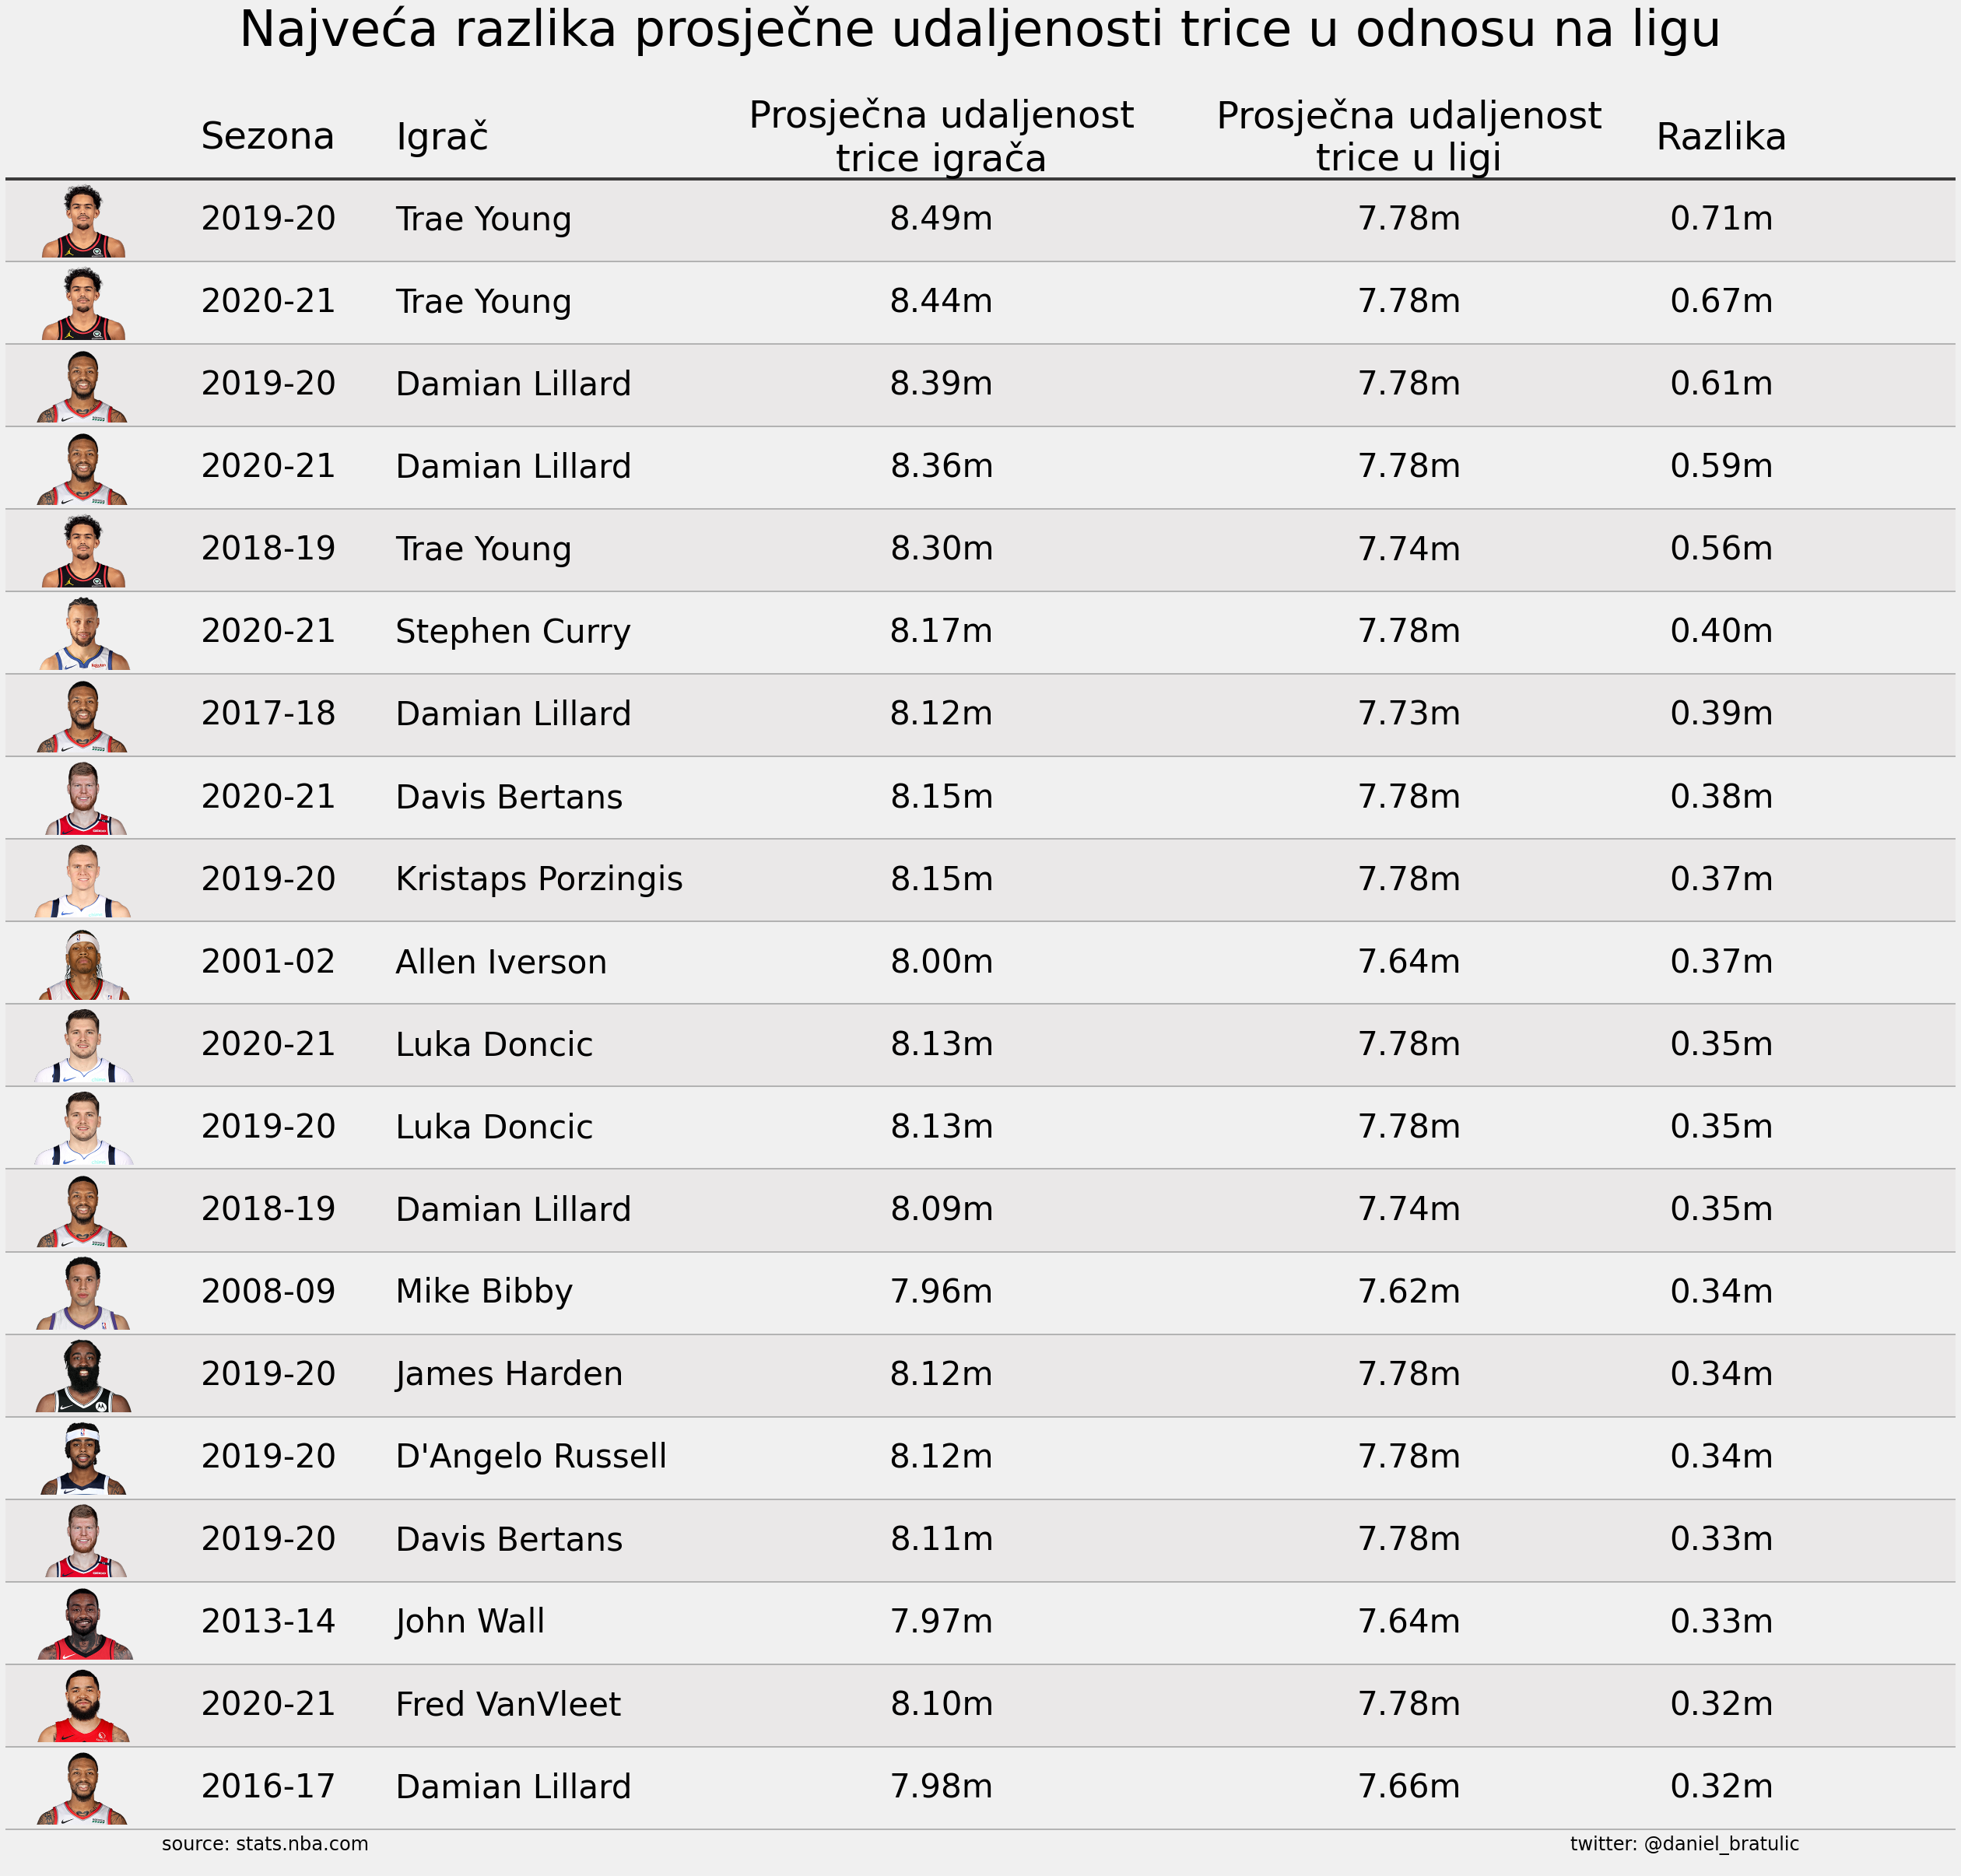

In [179]:
fig, ax = plt.subplots(figsize=(40, 40))
number_size = 42
font_size = 36
font_title = 48
title_size = 64
#top = 10

sorted_open_df = top_players
top = len(sorted_open_df)
for i in range(top):
    item = sorted_open_df.iloc[i]
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord + 0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
        
    ab = AnnotationBbox(get_player_img(find_players_by_full_name(item.PLAYER_NAME)[0]['id']), (0.1, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=number_size)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=item.PLAYER_NAME, size=number_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    ax.text(x=1.2, y=y_coord, ha='center', va='center', s=f"{item.CALC_DISTANCE_M:.2f}m", size=number_size)
    ax.text(x=1.8, y=y_coord, ha='center', va='center', s=f"{item.AVERAGE_DISTANCE_M:.2f}m", size=number_size)
    ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.DIFF_FROM_AVG_M:.2f}m", size=number_size)
    
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
ax.text(x=0.25, y=top, s='Sezona', ha='left', va='center', size=font_title)
ax.text(x=0.5, y=top, s='Igrač', ha='left', va='center', size=font_title)
ax.text(x=1.2, y=top, ha='center', va='center', s="Prosječna udaljenost\ntrice igrača", size=font_title)
ax.text(x=1.8, y=top, ha='center', va='center', s="Prosječna udaljenost\ntrice u ligi", size=font_title)
ax.text(x=2.2, y=top, ha='center', va='center', s="Razlika", size=font_title)
#ax.text(x=2.7, y=top, ha='center', va='center', s="% of shots in RA", size=font_title)

#ax.text(x=2.75, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=30)
#ax.text(x=0.25, y=-0.75, s='data: nba.com', ha='left', va='center', size=30)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Najveća razlika prosječne udaljenosti trice u odnosu na ligu", size=title_size)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0, right=2.5)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('table_wo_luck.png', dpi=120, bbox_inches='tight')
ax.text(x=2.3, y=-0.75, ha='right', s='twitter: @daniel_bratulic', size=24)
ax.text(x=0.2, y=-0.75, ha='left', s='source: stats.nba.com', size=24)

## Most furthest

In [181]:
top_distance = merged_distance.sort_values(by='CALC_DISTANCE_M', ascending=False).iloc[:20]

Text(0.2, -0.75, 'source: stats.nba.com')

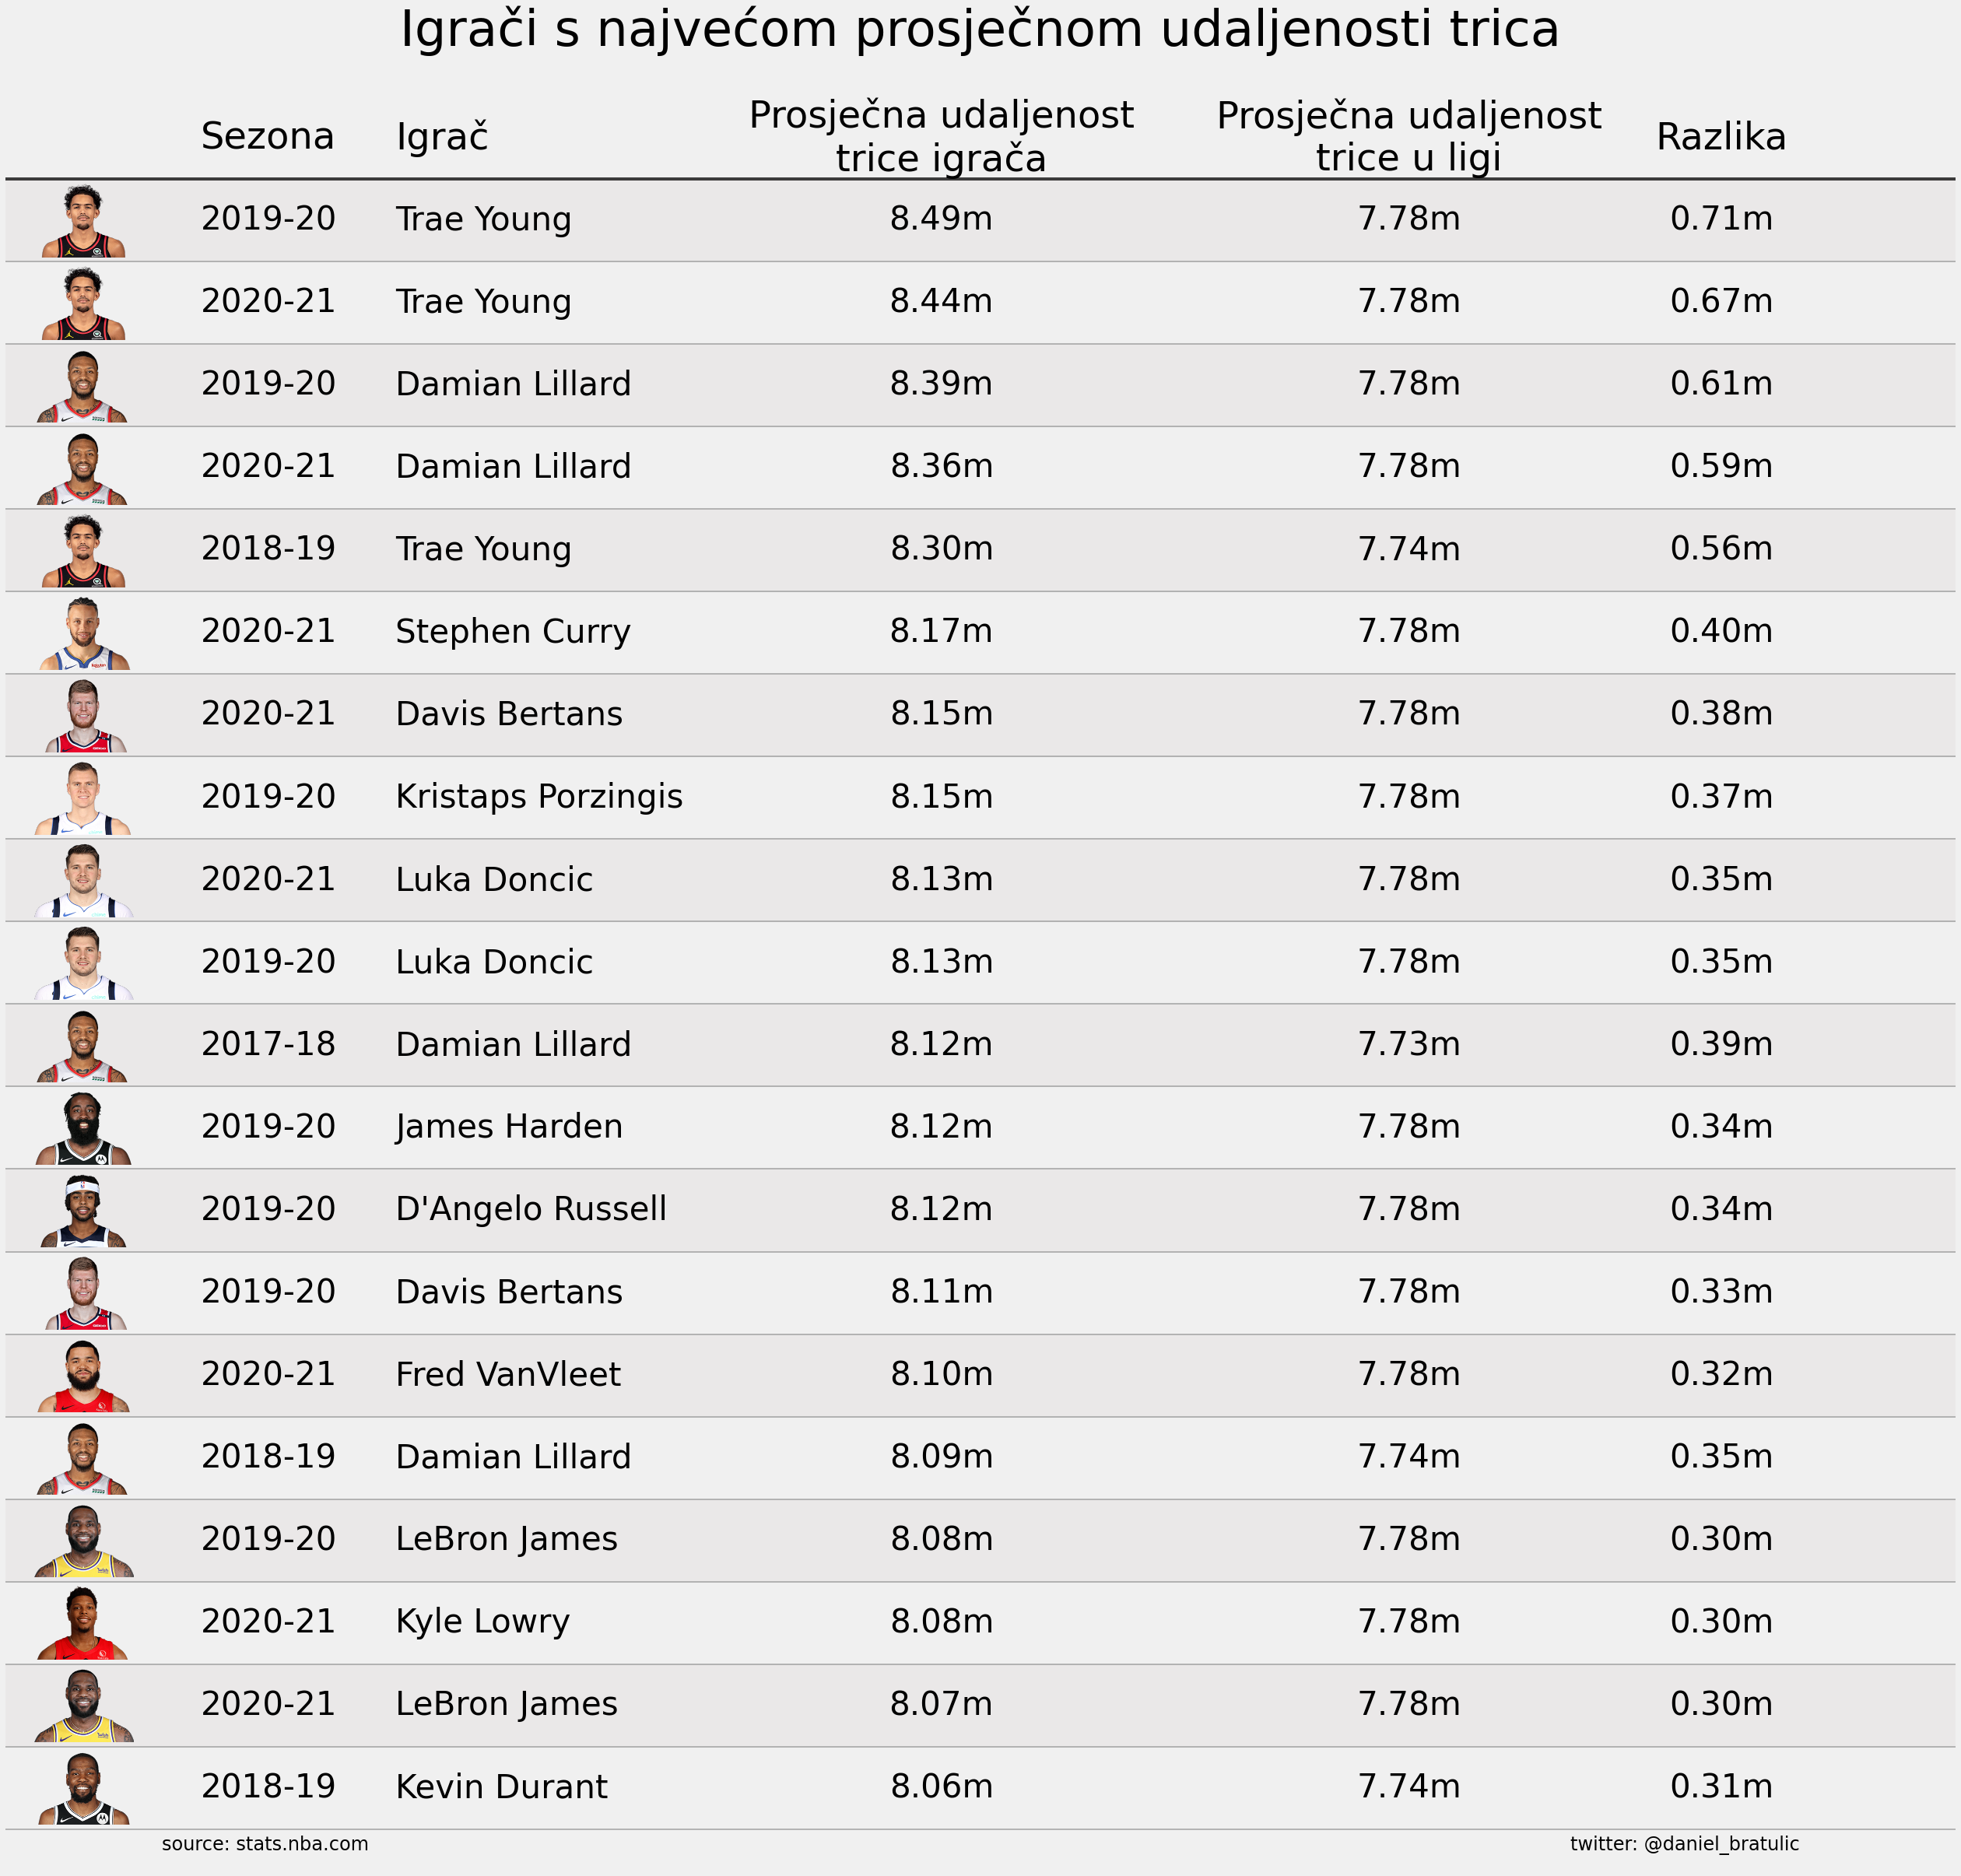

In [182]:
fig, ax = plt.subplots(figsize=(40, 40))
number_size = 42
font_size = 36
font_title = 48
title_size = 64
#top = 10

sorted_open_df = top_distance
top = len(top_distance)
for i in range(top):
    item = top_distance.iloc[i]
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord + 0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
        
    ab = AnnotationBbox(get_player_img(find_players_by_full_name(item.PLAYER_NAME)[0]['id']), (0.1, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=number_size)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=item.PLAYER_NAME, size=number_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    ax.text(x=1.2, y=y_coord, ha='center', va='center', s=f"{item.CALC_DISTANCE_M:.2f}m", size=number_size)
    ax.text(x=1.8, y=y_coord, ha='center', va='center', s=f"{item.AVERAGE_DISTANCE_M:.2f}m", size=number_size)
    ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.DIFF_FROM_AVG_M:.2f}m", size=number_size)
    
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
ax.text(x=0.25, y=top, s='Sezona', ha='left', va='center', size=font_title)
ax.text(x=0.5, y=top, s='Igrač', ha='left', va='center', size=font_title)
ax.text(x=1.2, y=top, ha='center', va='center', s="Prosječna udaljenost\ntrice igrača", size=font_title)
ax.text(x=1.8, y=top, ha='center', va='center', s="Prosječna udaljenost\ntrice u ligi", size=font_title)
ax.text(x=2.2, y=top, ha='center', va='center', s="Razlika", size=font_title)
#ax.text(x=2.7, y=top, ha='center', va='center', s="% of shots in RA", size=font_title)

#ax.text(x=2.75, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=30)
#ax.text(x=0.25, y=-0.75, s='data: nba.com', ha='left', va='center', size=30)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Igrači s najvećom prosječnom udaljenosti trica", size=title_size)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0, right=2.5)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('table_wo_luck.png', dpi=120, bbox_inches='tight')
ax.text(x=2.3, y=-0.75, ha='right', s='twitter: @daniel_bratulic', size=24)
ax.text(x=0.2, y=-0.75, ha='left', s='source: stats.nba.com', size=24)

## Stephen Curry

In [24]:
curry_alone = concated_averages.loc[concated_averages.PLAYER_NAME == 'Stephen Curry']

In [25]:
curry_alone.loc[curry_alone.CALC_DISTANCE >= 26.75].SHOT_MADE_FLAG.sum()

663

In [26]:
curry_alone.loc[curry_alone.CALC_DISTANCE >= 26.75].SHOT_ATTEMPTED_FLAG.sum()

1622

In [27]:
663 / 1622

0.4087546239210851

In [217]:
curry_alone.loc[curry_alone.CALC_DISTANCE_M > 8].groupby('SEASON').SHOT_ATTEMPTED_FLAG.sum()

SEASON
2009-10    121
2010-11     65
2011-12     36
2012-13    213
2013-14    192
2014-15    225
2015-16    298
2016-17    289
2017-18    168
2018-19    383
2019-20     31
2020-21    233
Name: SHOT_ATTEMPTED_FLAG, dtype: int64

In [216]:
curry_alone.groupby('SEASON').SHOT_ATTEMPTED_FLAG.sum()

SEASON
2009-10    374
2010-11    338
2011-12    121
2012-13    592
2013-14    609
2014-15    638
2015-16    871
2016-17    769
2017-18    493
2018-19    799
2019-20     49
2020-21    439
Name: SHOT_ATTEMPTED_FLAG, dtype: int64

In [221]:
233 / 439

0.530751708428246

## Lillard alone

In [29]:
dame_alone = concated_averages.loc[concated_averages.PLAYER_NAME == 'Damian Lillard']

In [31]:
dame_alone.loc[dame_alone.CALC_DISTANCE >= 26.75].SHOT_MADE_FLAG.sum()

568

In [32]:
dame_alone.loc[dame_alone.CALC_DISTANCE >= 26.75].SHOT_ATTEMPTED_FLAG.sum()

1566

In [33]:
568 / 1566

0.36270753512132825

In [218]:
dame_alone.loc[dame_alone.CALC_DISTANCE_M > 8].groupby('SEASON').SHOT_ATTEMPTED_FLAG.sum()


SEASON
2012-13     99
2013-14    116
2014-15    158
2015-16    163
2016-17    223
2017-18    328
2018-19    276
2019-20    389
2020-21    259
Name: SHOT_ATTEMPTED_FLAG, dtype: int64

In [219]:
dame_alone.groupby('SEASON').SHOT_ATTEMPTED_FLAG.sum()

SEASON
2012-13    500
2013-14    553
2014-15    570
2015-16    606
2016-17    577
2017-18    629
2018-19    641
2019-20    670
2020-21    460
Name: SHOT_ATTEMPTED_FLAG, dtype: int64

In [222]:
259/460

0.5630434782608695

### Trae

In [238]:
dame_alone = concated_averages.loc[concated_averages.PLAYER_NAME == 'Trae Young']

In [239]:
dame_alone.loc[dame_alone.CALC_DISTANCE_M > 8].groupby('SEASON').SHOT_ATTEMPTED_FLAG.sum()


SEASON
2018-19    267
2019-20    358
2020-21    174
Name: SHOT_ATTEMPTED_FLAG, dtype: int64

In [240]:
dame_alone.groupby('SEASON').SHOT_ATTEMPTED_FLAG.sum()

SEASON
2018-19    480
2019-20    568
2020-21    277
Name: SHOT_ATTEMPTED_FLAG, dtype: int64

### Get table for top 20 players in 3fg% 